#NLP on sexual harassment cases textual descriptions

The idea with this notebook is to work on Natural Language Processing tasks to extract features from the DESCRIPTION column of our dataset, to use them as input on a sexual-harassment-category classifier with more than 90% accuracy. Initially the idea is to some EDA and get familiar with the data, and to go through the model building pipeline: preprocessing, feature extraction, parameter tuning, model selection and testing.

In [1]:
!pip install polyglot
!pip install pyicu
!pip install pycld2
!pip install morfessor
!pip install wordcloud

     |████████████████████████████████| 133kB 8.8MB/s 
  Created wheel for polyglot: filename=polyglot-16.7.4-py2.py3-none-any.whl size=52560 sha256=c3d7d0d6aeb6fedb5991ea64ec5f265915497459c6b17fe7817d9c7c9080d824
  Stored in directory: /root/.cache/pip/wheels/5e/91/ef/f1369fdc1203b0a9347d4b24f149b83a305f39ab047986d9da
Successfully built polyglot
     |████████████████████████████████| 215kB 9.4MB/s 
  Created wheel for pyicu: filename=PyICU-2.3.1-cp36-cp36m-linux_x86_64.whl size=1172902 sha256=9c1fa0b712d2281b48d2dd42617d52486c3a2f81accb2664473f608b9529ce56
  Stored in directory: /root/.cache/pip/wheels/3f/45/7e/ccee9f1fe52787595e92641b5645cdf2cb40096749b39b4422
Successfully built pyicu
     |████████████████████████████████| 14.3MB 7.5MB/s 
  Created wheel for pycld2: filename=pycld2-0.31-cp36-cp36m-linux_x86_64.whl size=9825472 sha256=c277095cdb6221bdda3a8b552077f4400eab4822cbf5e64dd90986dbd8001bed
  Stored in directory: /root/.cache/pip/wheels/7b/44/44/ec4c5e25e095f02aa0e63ef2bf0cc

In [0]:
import re
import numpy as np
import pandas as pd
import folium
import nltk
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import polyglot

from os import path
from PIL import Image
from itertools import cycle
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords as sw
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from collections import Counter
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from polyglot.text import Text
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import svm

In [3]:
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')

!polyglot download embeddings2.en
!polyglot download ner2.en

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[polyglot_data] Downloading package embeddings2.en to
[polyglot_data]     /root/polyglot_data...
[polyglot_data] Downloading package ner2.en to /root/polyglot_data...


##EDA, Data Preprocessing and Feature Extraction


In [0]:
def category_desc_to_txt(df, category_list):
  
  #Collect all the descriptions in a text file, one per category(11)
  
  text = ['']*len(category_list)
  df_filtered_list = []
  counter = 0

  for category in category_list:
    df_filtered_list.append(df_train[df_train['CATEGORY'].str.contains(category)==True])

  for index in range(len(df_filtered_list)):
    for description in df_filtered_list[index].DESCRIPTION:
      text[index] = text[index] + ' ' + str(description)
      counter+=1
      if counter == int(report_1.shape[0]*split_rate):
        break

  category_list_names = []
  bad_chars = ['/', ' '] 

  for category in category_list:
    for i in bad_chars:
      category = category.replace(i, '')
    category_list_names.append(category.replace(i, ''))   

  for category, description in zip(category_list_names, text):
    f = open(category+'.txt',"w+")
    f.write(description)
    
  return category_list_names

In [21]:
#Read dataset and remove NA values
report_1 = pd.read_csv('safecity_reports_28072019.csv')

#Check the number of rows without a location (value==NaN)
print('Shape of df : ', report_1.shape)
print('\nDropping rows without description or location or category.....\n')
report_1 = report_1[pd.notna(report_1['DESCRIPTION'])]
report_1 = report_1[pd.notna(report_1['LONGITUDE'])]
report_1 = report_1[pd.notna(report_1['CATEGORY'])]
print('New shape of df : ', report_1.shape)

categories=[]
for index, row in report_1.iterrows():
    cat_group_list = [i for i in row.CATEGORY.split(',')]
    del(cat_group_list[-1])
    for category in cat_group_list:
      category = [category.lstrip()]
      if category not in categories:
        categories.append(category) #add a new category
      else:
        next
    #replace in the original df with the list. iat[] is to set a single row and 5 is the CATEGORY column index    
    if index == 11604:
      break
    report_1.iat[index, 5] = cat_group_list
    
print("Total number of unique categories : {}\n".format(len(categories)))
counts = [0] * len(categories)
category_list = [cat[0] for cat in categories]

#Split in train and test and create a collection of descriptions for each category
split_rate = 0.8
df_train = report_1.iloc[0:int(report_1.shape[0]*split_rate), :].copy()
df_test = report_1.iloc[int(report_1.shape[0]*split_rate)+1:,: ].copy()
fileNames = category_desc_to_txt(df_train, category_list) 

Shape of df :  (12122, 9)

Dropping rows without description or location or category.....

New shape of df :  (11604, 9)
Total number of unique categories : 14



[['Touching /Groping'], ['Catcalls/Whistles'], ['Sexual Invites'], ['Stalking'], ['Others'], ['Commenting'], ['Rape / Sexual Assault'], ['North East India Report'], ['Indecent exposure'], ['Chain Snatching'], ['Ogling/Facial Expressions/Staring'], ['Taking pictures'], ['Poor / No Street Lighting'], ['Online Harassment']]


### Tokenization, Lemmatization and Stemming
Top 20 most used words different outputs

In [0]:
def top20_and_allTokens(filename, stemming=True, lemmatization=True, plot=True):
  
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()
  category = open(filename, 'r')
  content = category.read().lower()
  pattern_wd_eng = (r'[A-Za-z]+') 
  
  print('\n', filename)
  
  #Tokenization
  tokens = re.findall(pattern_wd_eng, content)
  no_stops = [t for t in tqdm(tokens) if t not in sw.words('english')]
  
  print('Words and digits eng :\n', re.findall(pattern_wd_eng, content))
  print('\nSet() unique words and digits eng :\n', set(re.findall(pattern_wd_eng, content)))
  print('\nAfter nostop filter :\n', no_stops)
  
  top_20_a = Counter(no_stops).most_common(20)
  print('\nTop 20 most used words after non_stop:\n', top_20_a)
  
  #Lemmatization
  lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in no_stops]
  print('\nAfter lemmatizer :\n', lemmatized) if lemmatization else None
  top_20_b = Counter(lemmatized).most_common(20)
  print('\nTop 20 most used words after lemmatizer:\n', top_20_b) if lemmatization else None
  
  #Stemming
  stemmed = [stemmer.stem(word) for word in lemmatized]
  print('\nAfter stemmer :\n', stemmed) if stemming else None
  top_20 = Counter(stemmed).most_common(20)
  print('\nTop 20 most used words after stemmer:\n', top_20) if stemming else None
  
  top20_token = [word[0] for word in top_20]
  top20_count = [word[1] for word in top_20]
  
  if plot:
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 5)
    plt.bar(labels, values, color='g')
    plt.show()
    
  total_tokens = lemmatized if lemmatization else no_stops
  total_tokens = stemmed if stemming else total_tokens
  
  return total_tokens

### Tf_idf

In [0]:
def top20_tf_idf(category_tokens):
  
  # Build a dicitionary with all the unique tokens merging all categories
  dictionary = Dictionary(category_tokens)

  # Corpus: List(7 items) of list(for each collection) of tuples of word_id and count
  corpus = [dictionary.doc2bow(collection) for collection in category_tokens]

  print('\ncorpus: {}'.format(len(corpus)))
  
  # Create a new TfidfModel using the corpus: tfidf
  tfidf = TfidfModel(corpus)

  print('Top_20 after Term Frequency–Inverse Document Frequency')  
  
  for index, tokens_and_Cnt in enumerate(corpus):
    print('\n', fileNames[index])
    
  # Calculate the tfidf weights of doc: tfidf_weights
    tfidf_weights = tfidf[tokens_and_Cnt]

  # Sort the weights from highest to lowest: sorted_tfidf_weights
    sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

  # Print the top 5 weighted words
    for term_id, weight in sorted_tfidf_weights[0:20]:
      print(dictionary.get(term_id), weight)
      
  return corpus, dictionary, tfidf

In [10]:
#With BOTH lemmatization and Stemming
top20_and_allTokens_list = [top20_and_allTokens(fileNames[i]+'.txt', plot=False) for i in range(len(fileNames))]
categories_allTokens = [top20_and_allTokens_list[i] for i in range(len(top20_and_allTokens_list))]
corpus, dictionary, tfidf = top20_tf_idf(categories_allTokens)


 TouchingGroping.txt



Words and digits eng :
 ['pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'i', 'was', 'travelling', 'with', 'my', 'family', 'and', 'we', 'were', 'in', 'gurgaon', 'a', 'girl', 'with', 'a', 'boy', 'came', 'on', 'bike', 'and', 'the', 'girl', 'was', 'wearing', 'croptop', 'and', 'jeans', 'two', 'boys', 'in', 'a', 'car', 'came', 'behind', 'them', 'and', 'we', 'all', 'stopped', 'on', 'traffic', 'signal', 'and', 'those', 'boys', 'were', 'smoking', 'cigarettes', 'when', 'the', 'boys', 'saw', 'the', 'girl', 'they', 'put', 'their', 'burning', 'cigarettes', 'inside', 'the', 'jeans', 'of', 'the', 'girl', 'from', 'back', 'side', 'and', 'ran', 'away', 'and', 'the', 'girl', 'was', 'screaming', 'of', 'pain', 'i', 'noticed', 'the', 'people', 'standing', 'over', 'there', 'saying', 'that', 'it', 'was', 'the', 'fault', 'of', 'the', 'girl', 'as', 'she', 'was', 'wearing', 'short',


Words and digits eng :
 ['na', 'sexually', 'assaulting', 'three', 'boys', 'were', 'singing', 'a', 'song', 'as', 'i', 'passed', 'she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'it', 'was', 'during', 'my', 'coaching', 'our', 'classmates', 'used', 'to', 'follow', 'us', 'everywhere', 'we', 'used', 'to', 'go', 'and', 'pass', 'comments', 'on', 'our', 'dressing', 'and', 'our', 'body', 'language', 'it', 'felt', 'very', 'uncomfortable', 'it', 'was', 'around', 'pm', 'i', 'was', 'supposed', 'to


Words and digits eng :
 ['pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'sexually', 'assaulting', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'in', 'jaipur', 'my', 'college', 'backpack', 'i', 'worked', 'out', 'and', 'went', 'out', 'for', 'shopping', 'i', 'was', 'pumped', 'up', 'a', 'year', 'old', 'sikh', 'man', 'on', 'a', 'splender', 'bike', 'came', 'to', 'me', 'and', 'directly', 'asked', 'me', 'to', 'have', 'sex', 'with', 'hi', 'at', 'various', 'apps', 'like', 'webchat', 'and', 'all', 'i', 'do', 'showoff', 'little', 'bi', 'and', 'have', 'been', 'approached', 'and', 'asked', 'gay', 'relations', 'until', 'and', 'unless', 'strong', 'punishments', 'live', 'non', 'bailable', 'prison', 'for', 'min', 'years', 'or', 'death', 'punishment', 'rape', 'has', 'happened', 'ar


Words and digits eng :
 ['na', 'pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'she', 'works', 'as', 'a', 'field', 'coordinator', 'and', 'around', 'an', 'year', 'back', 'a', 'man', 'followed', 'her', 'and', 'asked', 'her', 'contact', 'details', 'she', 'is', 'student', 'and', 'she', 'doesn', 't', 'feels', 'safe', 'at', 'all', 'at', 'the', 'station', 'and', 'she', 'faces', 'assault', 'almost', 'daily', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'molesters', 'saw', 'my', 'friend', 'on', 'her', 'vehicle', 'near', 'babari', 'mandi', 'and', 'while', 'they', 'were', 'about', 'to', 'leave', 'they', 'tried', 'to', 'get', 'hold', 'of', 'her', 'pallu', 'while', 


Words and digits eng :
 ['i', 'got', 'this', 'issue', 'known', 'from', 'my', 'senior', 'in', 'my', 'college', 'one', 'of', 'the', 'adhoc', 'professors', 'used', 'to', 'ask', 'his', 'girl', 'students', 'why', 'they', 'are', 'not', 'accepting', 'their', 'friend', 'request', 'in', 'fb', 'and', 'sometimes', 'to', 'go', 'out', 'for', 'coffee', 'and', 'asks', 'to', 'come', 'alone', 'in', 'his', 'cabin', 'to', 'discuss', 'things', 'during', 'holi', 'celebration', 'a', 'male', 'employee', 'applied', 'colour', 'inside', 'a', 'female', 'employees', 'mouth', 'and', 'poured', 'water', 'over', 'her', 'within', 'the', 'office', 'premises', 'she', 'was', 'not', 'okay', 'with', 'it', 'and', 'reported', 'the', 'matter', 'i', 'saw', 'a', 'man', 'who', 'does', 'nothing', 'but', 'due', 'to', 'some', 'kind', 'of', 'misunderstanding', 'regarding', 'atm', 'a', 'lot', 'of', 'people', 'hit', 'him', 'he', 'was', 'following', 'me', 'since', 'days', 'i', 'was', 'on', 'a', 'rickshaw', 'with', 'my', 'friend', 'two


Words and digits eng :
 ['sexually', 'assaulting', 'we', 'were', 'going', 'back', 'to', 'our', 'place', 'after', 'visiting', 'our', 'friend', 'so', 'as', 'we', 'were', 'going', 'to', 'the', 'ticket', 'counter', 'on', 'the', 'way', 'there', 'were', 'some', 'goons', 'kind', 'of', 'people', 'sitting', 'on', 'their', 'bikes', 'passed', 'comments', 'at', 'us', 'she', 'does', 'not', 'feels', 'safe', 'during', 'night', 'journeys', 'she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'she', 'works', 'as', 'a', 'field', 'coordinator', 'and', 'around', 'an', 'year', 'back', 'a', 'man', 'followed', 'her', 'and', 'asked', 'her', 'contact', 'details', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'bee


Words and digits eng :
 ['sexually', 'assaulting', 'year', 'old', 'girl', 'playing', 'in', 'the', 'temple', 'with', 'her', 'friends', 'and', 'after', 'some', 'time', 'she', 'disappeared', 'and', 'after', 'hours', 'she', 'got', 'raped', 'a', 'minor', 'tribal', 'girl', 'was', 'raped', 'by', 'few', 'men', 'and', 'was', 'dumped', 'was', 'taking', 'pictures', 'was', 'taking', 'pictures', 'was', 'taking', 'pictures']

Set() unique words and digits eng :
 {'in', 'and', 'a', 'the', 'she', 'minor', 'playing', 'men', 'her', 'after', 'taking', 'some', 'disappeared', 'time', 'with', 'girl', 'few', 'was', 'year', 'old', 'dumped', 'hours', 'tribal', 'temple', 'sexually', 'pictures', 'raped', 'got', 'friends', 'assaulting', 'by'}

After nostop filter :
 ['sexually', 'assaulting', 'year', 'old', 'girl', 'playing', 'temple', 'friends', 'time', 'disappeared', 'hours', 'got', 'raped', 'minor', 'tribal', 'girl', 'raped', 'men', 'dumped', 'taking', 'pictures', 'taking', 'pictures', 'taking', 'pictures']




Words and digits eng :
 ['we', 'conducted', 'a', 'survey', 'as', 'part', 'of', 'our', 'sociology', 'assignment', 'course', 'offered', 'in', 'iit', 'the', 'women', 'workers', 'in', 'the', 'construction', 'site', 'said', 'they', 'were', 'sexually', 'assaulted', 'in', 'a', 'beer', 'bar', 'after', 'it', 'closed', 'two', 'girls', 'who', 'were', 'there', 'are', 'hit', 'by', 'some', 'men', 'when', 'she', 'refused', 'to', 'go', 'with', 'them']

Set() unique words and digits eng :
 {'were', 'in', 'two', 'there', 'iit', 'are', 'closed', 'refused', 'workers', 'survey', 'beer', 'conducted', 'a', 'assignment', 'go', 'the', 'she', 'as', 'it', 'to', 'said', 'assaulted', 'part', 'who', 'men', 'after', 'we', 'offered', 'when', 'girls', 'some', 'women', 'hit', 'with', 'them', 'course', 'site', 'of', 'sociology', 'bar', 'they', 'our', 'sexually', 'construction', 'by'}

After nostop filter :
 ['conducted', 'survey', 'part', 'sociology', 'assignment', 'course', 'offered', 'iit', 'women', 'workers', 'const


Words and digits eng :
 ['sexually', 'assaulting', 'it', 'was', 'pm', 'in', 'a', 'non', 'ac', 'bmtc', 'bus', 'after', 'bellandur', 'petrol', 'pump', 'stop', 'since', 'there', 'was', 'a', 'lot', 'of', 'rush', 'a', 'man', 'middle', 'aged', 'looked', 'innocent', 'started', 'masturbating', 'by', 'tying', 'a', 'plastic', 'around', 'his', 'privates', 'and', 'hiding', 'the', 'other', 'side', 'by', 'his', 'bag', 'he', 'started', 'pretending', 'when', 'i', 'screamed', 'and', 'tied', 'to', 'escape', 'i', 'was', 'travelling', 'in', 'the', 'delhi', 'metro', 'and', 'a', 'man', 'was', 'staring', 'at', 'a', 'girl', 'with', 'the', 'intention', 'full', 'of', 'lust', 'after', 'a', 'decent', 'amount', 'of', 'time', 'i', 'couldn', 't', 'take', 'it', 'and', 'i', 'stood', 'in', 'his', 'point', 'of', 'view', 'and', 'gave', 'him', 'a', 'casual', 'look', 'fortunately', 'that', 'sent', 'the', 'message']

Set() unique words and digits eng :
 {'delhi', 'side', 't', 'in', 'bellandur', 'there', 'plastic', 'his', '


Words and digits eng :
 ['chain', 'snatching', 'by', 'two', 'bikers', 'only', 'rider', 'wearing', 'helmet', 'at', 'am', 'snatched', 'chain', 'from', 'my', 'friend', 'when', 'i', 'was', 'with', 'her', 'police', 'didn', 't', 'take', 'any', 'action', 'i', 'was', 'travelling', 'in', 'the', 'delhi', 'metro', 'and', 'a', 'man', 'was', 'staring', 'at', 'a', 'girl', 'with', 'the', 'intention', 'full', 'of', 'lust', 'after', 'a', 'decent', 'amount', 'of', 'time', 'i', 'couldn', 't', 'take', 'it', 'and', 'i', 'stood', 'in', 'his', 'point', 'of', 'view', 'and', 'gave', 'him', 'a', 'casual', 'look', 'fortunately', 'that', 'sent', 'the', 'message', 'i', 'witnessed', 'a', 'chain', 'robbery', 'a', 'gang', 'of', 'goon', 'looted', 'me', 'outside', 'the', 'raniganj', 'station', 'few', 'people', 'followed', 'me', 'to', 'my', 'home', 'and', 'also', 'pelted', 'stone', 'at', 'me', 'and', 'comments', 'continuously', 'a', 'biker', 'snatched', 'my', 'gold', 'chain', 'flee', 'from', 'there', 'chain', 'snatchin


Words and digits eng :
 ['sexually', 'assaulting', 'sometimes', 'its', 'safe', 'and', 'sometimes', 'it', 'isn', 't', 'and', 'the', 'reason', 'is', 'crowd', 'only', 'it', 'happens', 'with', 'her', 'almost', 'every', 'second', 'day', 'she', 'is', 'student', 'and', 'she', 'doesn', 't', 'feels', 'safe', 'at', 'all', 'at', 'the', 'station', 'and', 'she', 'faces', 'assault', 'almost', 'daily', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'while', 'boarding', 'the', 'train', 'there', 'were', 'was', 'a', 'person', 'who', 'was', 'passing', 'cheap', 'comments', 'a', 'man', 'was', 'staring', 'for', 'the', 'past', 'years', 'i', 've', 'been', 'stared', 'at


Words and digits eng :
 ['she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'it', 'was', 'during', 'my', 'coaching', 'our', 'classmates', 'used', 'to', 'follow', 'us', 'everywhere', 'we', 'used', 'to', 'go', 'and', 'pass', 'comments', 'on', 'our', 'dressing', 'and', 'our', 'body', 'language', 'it', 'felt', 'very', 'uncomfortable', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'a', 'man', 'came', 'on', 'a', 'bike', 'and', 'was', 'offering', 'liftvto', 'young', 'girls', 'while', 'coming', 'from', 'classes', 'i', 'saw', 'a', 'group', 'of', 'boys', 'were', 'teasing', 'a', 'girl', 'taking', 'pictures', 'verbal', 'teasing', 'one', 'evening', 'inside', 'the', 'first', 'class', 'compartment', 'a', 'guy', 'was', 'staring', 'at', 'my', 'friend', 'and', 'then', 'tried', 'to', 'touch', 'her', 'a', 'man', 'thought', 'i', 'was', 'a', 'prostitute', 'and', 'was', 'offering', 'money', 'for', 'one', 'night', 'was', '


Words and digits eng :
 ['she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'i', 'work', 'in', 'a', 'factory', 'in', 'bengaluru', 'rural', 'area', 'the', 'street', 'which', 'leads', 'to', 'the', 'factory', 'where', 'i', 'work', 'has', 'no', 'street', 'lights', 'at', 'all', 'it', 'becomes', 'extremely', 'difficult', 'for', 'those', 'who', 'have', 'to', 'go', 'to', 'work', 'in', 'the', 'night', 'shift', 'sometimes', 'even', 'robbery', 'also', 'takes', 'place', 'by', 'strangers', 'one', 'day', 'a', 'group', 'of', 'people', 'came', 'onto', 'me', 'and', 'i', 'was', 'mugged', 'they', 'took', 'my', 'phone', 'and', 'wallet', 'in', 'a', 'beer', 'bar', 'after', 'it', 'closed', 'two', 'girls', 'who', 'were', 'there', 'are', 'hit', 'by', 'some', 'men', 'when', 'she', 'refused', 'to', 'go', 'with', 'them', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'a', 'man', 'came', 'on', 'a', 'bik


Words and digits eng :
 []

Set() unique words and digits eng :
 set()

After nostop filter :
 []

Top 20 most used words after non_stop:
 []

After lemmatizer :
 []

Top 20 most used words after lemmatizer:
 []

After stemmer :
 []

Top 20 most used words after stemmer:
 []

corpus: 14
Top_20 after Term Frequency–Inverse Document Frequency

 TouchingGroping
touch 0.320094587328357
think 0.1584567489134669
happen 0.15618966003780863
behind 0.1280378349313428
wear 0.1280378349313428
bu 0.1232441380438076
minut 0.12130428991292244
put 0.12130428991292244
turn 0.12130428991292244
chang 0.10967583320462704
cigarett 0.10967583320462704
cloth 0.10967583320462704
grope 0.10967583320462704
jean 0.10967583320462704
manner 0.10967583320462704
mean 0.10967583320462704
modern 0.10967583320462704
mom 0.10967583320462704
short 0.10967583320462704
signal 0.10967583320462704

 CatcallsWhistles
pictur 0.22048054906576722
circl 0.17168130484352545
heavi 0.17168130484352545
inner 0.17168130484352545
sin

In [11]:
#Without stemming
top20_and_allTokens_list = [top20_and_allTokens(fileNames[i]+'.txt', stemming=False, plot=False) for i in range(len(fileNames))]
categories_allTokens = [top20_and_allTokens_list[i] for i in range(len(top20_and_allTokens_list))]
corpus, dictionary, tfidf = top20_tf_idf(categories_allTokens)


 TouchingGroping.txt



Words and digits eng :
 ['pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'i', 'was', 'travelling', 'with', 'my', 'family', 'and', 'we', 'were', 'in', 'gurgaon', 'a', 'girl', 'with', 'a', 'boy', 'came', 'on', 'bike', 'and', 'the', 'girl', 'was', 'wearing', 'croptop', 'and', 'jeans', 'two', 'boys', 'in', 'a', 'car', 'came', 'behind', 'them', 'and', 'we', 'all', 'stopped', 'on', 'traffic', 'signal', 'and', 'those', 'boys', 'were', 'smoking', 'cigarettes', 'when', 'the', 'boys', 'saw', 'the', 'girl', 'they', 'put', 'their', 'burning', 'cigarettes', 'inside', 'the', 'jeans', 'of', 'the', 'girl', 'from', 'back', 'side', 'and', 'ran', 'away', 'and', 'the', 'girl', 'was', 'screaming', 'of', 'pain', 'i', 'noticed', 'the', 'people', 'standing', 'over', 'there', 'saying', 'that', 'it', 'was', 'the', 'fault', 'of', 'the', 'girl', 'as', 'she', 'was', 'wearing', 'short',


Words and digits eng :
 ['na', 'sexually', 'assaulting', 'three', 'boys', 'were', 'singing', 'a', 'song', 'as', 'i', 'passed', 'she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'it', 'was', 'during', 'my', 'coaching', 'our', 'classmates', 'used', 'to', 'follow', 'us', 'everywhere', 'we', 'used', 'to', 'go', 'and', 'pass', 'comments', 'on', 'our', 'dressing', 'and', 'our', 'body', 'language', 'it', 'felt', 'very', 'uncomfortable', 'it', 'was', 'around', 'pm', 'i', 'was', 'supposed', 'to


Words and digits eng :
 ['pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'sexually', 'assaulting', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'in', 'jaipur', 'my', 'college', 'backpack', 'i', 'worked', 'out', 'and', 'went', 'out', 'for', 'shopping', 'i', 'was', 'pumped', 'up', 'a', 'year', 'old', 'sikh', 'man', 'on', 'a', 'splender', 'bike', 'came', 'to', 'me', 'and', 'directly', 'asked', 'me', 'to', 'have', 'sex', 'with', 'hi', 'at', 'various', 'apps', 'like', 'webchat', 'and', 'all', 'i', 'do', 'showoff', 'little', 'bi', 'and', 'have', 'been', 'approached', 'and', 'asked', 'gay', 'relations', 'until', 'and', 'unless', 'strong', 'punishments', 'live', 'non', 'bailable', 'prison', 'for', 'min', 'years', 'or', 'death', 'punishment', 'rape', 'has', 'happened', 'ar


Words and digits eng :
 ['na', 'pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'she', 'works', 'as', 'a', 'field', 'coordinator', 'and', 'around', 'an', 'year', 'back', 'a', 'man', 'followed', 'her', 'and', 'asked', 'her', 'contact', 'details', 'she', 'is', 'student', 'and', 'she', 'doesn', 't', 'feels', 'safe', 'at', 'all', 'at', 'the', 'station', 'and', 'she', 'faces', 'assault', 'almost', 'daily', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'molesters', 'saw', 'my', 'friend', 'on', 'her', 'vehicle', 'near', 'babari', 'mandi', 'and', 'while', 'they', 'were', 'about', 'to', 'leave', 'they', 'tried', 'to', 'get', 'hold', 'of', 'her', 'pallu', 'while', 


Words and digits eng :
 ['i', 'got', 'this', 'issue', 'known', 'from', 'my', 'senior', 'in', 'my', 'college', 'one', 'of', 'the', 'adhoc', 'professors', 'used', 'to', 'ask', 'his', 'girl', 'students', 'why', 'they', 'are', 'not', 'accepting', 'their', 'friend', 'request', 'in', 'fb', 'and', 'sometimes', 'to', 'go', 'out', 'for', 'coffee', 'and', 'asks', 'to', 'come', 'alone', 'in', 'his', 'cabin', 'to', 'discuss', 'things', 'during', 'holi', 'celebration', 'a', 'male', 'employee', 'applied', 'colour', 'inside', 'a', 'female', 'employees', 'mouth', 'and', 'poured', 'water', 'over', 'her', 'within', 'the', 'office', 'premises', 'she', 'was', 'not', 'okay', 'with', 'it', 'and', 'reported', 'the', 'matter', 'i', 'saw', 'a', 'man', 'who', 'does', 'nothing', 'but', 'due', 'to', 'some', 'kind', 'of', 'misunderstanding', 'regarding', 'atm', 'a', 'lot', 'of', 'people', 'hit', 'him', 'he', 'was', 'following', 'me', 'since', 'days', 'i', 'was', 'on', 'a', 'rickshaw', 'with', 'my', 'friend', 'two


Words and digits eng :
 ['sexually', 'assaulting', 'we', 'were', 'going', 'back', 'to', 'our', 'place', 'after', 'visiting', 'our', 'friend', 'so', 'as', 'we', 'were', 'going', 'to', 'the', 'ticket', 'counter', 'on', 'the', 'way', 'there', 'were', 'some', 'goons', 'kind', 'of', 'people', 'sitting', 'on', 'their', 'bikes', 'passed', 'comments', 'at', 'us', 'she', 'does', 'not', 'feels', 'safe', 'during', 'night', 'journeys', 'she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'she', 'works', 'as', 'a', 'field', 'coordinator', 'and', 'around', 'an', 'year', 'back', 'a', 'man', 'followed', 'her', 'and', 'asked', 'her', 'contact', 'details', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'bee


Words and digits eng :
 ['sexually', 'assaulting', 'year', 'old', 'girl', 'playing', 'in', 'the', 'temple', 'with', 'her', 'friends', 'and', 'after', 'some', 'time', 'she', 'disappeared', 'and', 'after', 'hours', 'she', 'got', 'raped', 'a', 'minor', 'tribal', 'girl', 'was', 'raped', 'by', 'few', 'men', 'and', 'was', 'dumped', 'was', 'taking', 'pictures', 'was', 'taking', 'pictures', 'was', 'taking', 'pictures']

Set() unique words and digits eng :
 {'in', 'and', 'a', 'the', 'she', 'minor', 'playing', 'men', 'her', 'after', 'taking', 'some', 'disappeared', 'time', 'with', 'girl', 'few', 'was', 'year', 'old', 'dumped', 'hours', 'tribal', 'temple', 'sexually', 'pictures', 'raped', 'got', 'friends', 'assaulting', 'by'}

After nostop filter :
 ['sexually', 'assaulting', 'year', 'old', 'girl', 'playing', 'temple', 'friends', 'time', 'disappeared', 'hours', 'got', 'raped', 'minor', 'tribal', 'girl', 'raped', 'men', 'dumped', 'taking', 'pictures', 'taking', 'pictures', 'taking', 'pictures']




Words and digits eng :
 ['we', 'conducted', 'a', 'survey', 'as', 'part', 'of', 'our', 'sociology', 'assignment', 'course', 'offered', 'in', 'iit', 'the', 'women', 'workers', 'in', 'the', 'construction', 'site', 'said', 'they', 'were', 'sexually', 'assaulted', 'in', 'a', 'beer', 'bar', 'after', 'it', 'closed', 'two', 'girls', 'who', 'were', 'there', 'are', 'hit', 'by', 'some', 'men', 'when', 'she', 'refused', 'to', 'go', 'with', 'them']

Set() unique words and digits eng :
 {'were', 'in', 'two', 'there', 'iit', 'are', 'closed', 'refused', 'workers', 'survey', 'beer', 'conducted', 'a', 'assignment', 'go', 'the', 'she', 'as', 'it', 'to', 'said', 'assaulted', 'part', 'who', 'men', 'after', 'we', 'offered', 'when', 'girls', 'some', 'women', 'hit', 'with', 'them', 'course', 'site', 'of', 'sociology', 'bar', 'they', 'our', 'sexually', 'construction', 'by'}

After nostop filter :
 ['conducted', 'survey', 'part', 'sociology', 'assignment', 'course', 'offered', 'iit', 'women', 'workers', 'const


Words and digits eng :
 ['sexually', 'assaulting', 'it', 'was', 'pm', 'in', 'a', 'non', 'ac', 'bmtc', 'bus', 'after', 'bellandur', 'petrol', 'pump', 'stop', 'since', 'there', 'was', 'a', 'lot', 'of', 'rush', 'a', 'man', 'middle', 'aged', 'looked', 'innocent', 'started', 'masturbating', 'by', 'tying', 'a', 'plastic', 'around', 'his', 'privates', 'and', 'hiding', 'the', 'other', 'side', 'by', 'his', 'bag', 'he', 'started', 'pretending', 'when', 'i', 'screamed', 'and', 'tied', 'to', 'escape', 'i', 'was', 'travelling', 'in', 'the', 'delhi', 'metro', 'and', 'a', 'man', 'was', 'staring', 'at', 'a', 'girl', 'with', 'the', 'intention', 'full', 'of', 'lust', 'after', 'a', 'decent', 'amount', 'of', 'time', 'i', 'couldn', 't', 'take', 'it', 'and', 'i', 'stood', 'in', 'his', 'point', 'of', 'view', 'and', 'gave', 'him', 'a', 'casual', 'look', 'fortunately', 'that', 'sent', 'the', 'message']

Set() unique words and digits eng :
 {'delhi', 'side', 't', 'in', 'bellandur', 'there', 'plastic', 'his', '


Words and digits eng :
 ['chain', 'snatching', 'by', 'two', 'bikers', 'only', 'rider', 'wearing', 'helmet', 'at', 'am', 'snatched', 'chain', 'from', 'my', 'friend', 'when', 'i', 'was', 'with', 'her', 'police', 'didn', 't', 'take', 'any', 'action', 'i', 'was', 'travelling', 'in', 'the', 'delhi', 'metro', 'and', 'a', 'man', 'was', 'staring', 'at', 'a', 'girl', 'with', 'the', 'intention', 'full', 'of', 'lust', 'after', 'a', 'decent', 'amount', 'of', 'time', 'i', 'couldn', 't', 'take', 'it', 'and', 'i', 'stood', 'in', 'his', 'point', 'of', 'view', 'and', 'gave', 'him', 'a', 'casual', 'look', 'fortunately', 'that', 'sent', 'the', 'message', 'i', 'witnessed', 'a', 'chain', 'robbery', 'a', 'gang', 'of', 'goon', 'looted', 'me', 'outside', 'the', 'raniganj', 'station', 'few', 'people', 'followed', 'me', 'to', 'my', 'home', 'and', 'also', 'pelted', 'stone', 'at', 'me', 'and', 'comments', 'continuously', 'a', 'biker', 'snatched', 'my', 'gold', 'chain', 'flee', 'from', 'there', 'chain', 'snatchin


Words and digits eng :
 ['sexually', 'assaulting', 'sometimes', 'its', 'safe', 'and', 'sometimes', 'it', 'isn', 't', 'and', 'the', 'reason', 'is', 'crowd', 'only', 'it', 'happens', 'with', 'her', 'almost', 'every', 'second', 'day', 'she', 'is', 'student', 'and', 'she', 'doesn', 't', 'feels', 'safe', 'at', 'all', 'at', 'the', 'station', 'and', 'she', 'faces', 'assault', 'almost', 'daily', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'while', 'boarding', 'the', 'train', 'there', 'were', 'was', 'a', 'person', 'who', 'was', 'passing', 'cheap', 'comments', 'a', 'man', 'was', 'staring', 'for', 'the', 'past', 'years', 'i', 've', 'been', 'stared', 'at


Words and digits eng :
 ['she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'it', 'was', 'during', 'my', 'coaching', 'our', 'classmates', 'used', 'to', 'follow', 'us', 'everywhere', 'we', 'used', 'to', 'go', 'and', 'pass', 'comments', 'on', 'our', 'dressing', 'and', 'our', 'body', 'language', 'it', 'felt', 'very', 'uncomfortable', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'a', 'man', 'came', 'on', 'a', 'bike', 'and', 'was', 'offering', 'liftvto', 'young', 'girls', 'while', 'coming', 'from', 'classes', 'i', 'saw', 'a', 'group', 'of', 'boys', 'were', 'teasing', 'a', 'girl', 'taking', 'pictures', 'verbal', 'teasing', 'one', 'evening', 'inside', 'the', 'first', 'class', 'compartment', 'a', 'guy', 'was', 'staring', 'at', 'my', 'friend', 'and', 'then', 'tried', 'to', 'touch', 'her', 'a', 'man', 'thought', 'i', 'was', 'a', 'prostitute', 'and', 'was', 'offering', 'money', 'for', 'one', 'night', 'was', '


Words and digits eng :
 ['she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'i', 'work', 'in', 'a', 'factory', 'in', 'bengaluru', 'rural', 'area', 'the', 'street', 'which', 'leads', 'to', 'the', 'factory', 'where', 'i', 'work', 'has', 'no', 'street', 'lights', 'at', 'all', 'it', 'becomes', 'extremely', 'difficult', 'for', 'those', 'who', 'have', 'to', 'go', 'to', 'work', 'in', 'the', 'night', 'shift', 'sometimes', 'even', 'robbery', 'also', 'takes', 'place', 'by', 'strangers', 'one', 'day', 'a', 'group', 'of', 'people', 'came', 'onto', 'me', 'and', 'i', 'was', 'mugged', 'they', 'took', 'my', 'phone', 'and', 'wallet', 'in', 'a', 'beer', 'bar', 'after', 'it', 'closed', 'two', 'girls', 'who', 'were', 'there', 'are', 'hit', 'by', 'some', 'men', 'when', 'she', 'refused', 'to', 'go', 'with', 'them', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'a', 'man', 'came', 'on', 'a', 'bik


Words and digits eng :
 []

Set() unique words and digits eng :
 set()

After nostop filter :
 []

Top 20 most used words after non_stop:
 []

After lemmatizer :
 []

Top 20 most used words after lemmatizer:
 []

corpus: 14
Top_20 after Term Frequency–Inverse Document Frequency

 TouchingGroping
touch 0.31755098302308
think 0.15719758588887306
happen 0.15494851224137815
behind 0.127020393209232
wear 0.127020393209232
bus 0.12226478902467905
minutes 0.12034035573132204
private 0.12034035573132204
put 0.12034035573132204
turn 0.12034035573132204
change 0.10880430356130333
cigarettes 0.10880430356130333
clothe 0.10880430356130333
grope 0.10880430356130333
jeans 0.10880430356130333
manner 0.10880430356130333
mean 0.10880430356130333
modern 0.10880430356130333
mom 0.10880430356130333
short 0.10880430356130333

 CatcallsWhistles
picture 0.21878938141077772
circle 0.17036444550628224
heavy 0.17036444550628224
inner 0.17036444550628224
sing 0.17036444550628224
song 0.17036444550628224
three 0

In [12]:
#Without lemmatization nor stemming
top20_and_allTokens_list = [top20_and_allTokens(fileNames[i]+'.txt', stemming=False, lemmatization=False, plot=False) for i in range(len(fileNames))]
categories_allTokens = [top20_and_allTokens_list[i] for i in range(len(top20_and_allTokens_list))]
corpus, dictionary, tfidf = top20_tf_idf(categories_allTokens)


 TouchingGroping.txt



Words and digits eng :
 ['pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'i', 'was', 'travelling', 'with', 'my', 'family', 'and', 'we', 'were', 'in', 'gurgaon', 'a', 'girl', 'with', 'a', 'boy', 'came', 'on', 'bike', 'and', 'the', 'girl', 'was', 'wearing', 'croptop', 'and', 'jeans', 'two', 'boys', 'in', 'a', 'car', 'came', 'behind', 'them', 'and', 'we', 'all', 'stopped', 'on', 'traffic', 'signal', 'and', 'those', 'boys', 'were', 'smoking', 'cigarettes', 'when', 'the', 'boys', 'saw', 'the', 'girl', 'they', 'put', 'their', 'burning', 'cigarettes', 'inside', 'the', 'jeans', 'of', 'the', 'girl', 'from', 'back', 'side', 'and', 'ran', 'away', 'and', 'the', 'girl', 'was', 'screaming', 'of', 'pain', 'i', 'noticed', 'the', 'people', 'standing', 'over', 'there', 'saying', 'that', 'it', 'was', 'the', 'fault', 'of', 'the', 'girl', 'as', 'she', 'was', 'wearing', 'short',


Words and digits eng :
 ['na', 'sexually', 'assaulting', 'three', 'boys', 'were', 'singing', 'a', 'song', 'as', 'i', 'passed', 'she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'it', 'was', 'during', 'my', 'coaching', 'our', 'classmates', 'used', 'to', 'follow', 'us', 'everywhere', 'we', 'used', 'to', 'go', 'and', 'pass', 'comments', 'on', 'our', 'dressing', 'and', 'our', 'body', 'language', 'it', 'felt', 'very', 'uncomfortable', 'it', 'was', 'around', 'pm', 'i', 'was', 'supposed', 'to


Words and digits eng :
 ['pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'sexually', 'assaulting', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'in', 'jaipur', 'my', 'college', 'backpack', 'i', 'worked', 'out', 'and', 'went', 'out', 'for', 'shopping', 'i', 'was', 'pumped', 'up', 'a', 'year', 'old', 'sikh', 'man', 'on', 'a', 'splender', 'bike', 'came', 'to', 'me', 'and', 'directly', 'asked', 'me', 'to', 'have', 'sex', 'with', 'hi', 'at', 'various', 'apps', 'like', 'webchat', 'and', 'all', 'i', 'do', 'showoff', 'little', 'bi', 'and', 'have', 'been', 'approached', 'and', 'asked', 'gay', 'relations', 'until', 'and', 'unless', 'strong', 'punishments', 'live', 'non', 'bailable', 'prison', 'for', 'min', 'years', 'or', 'death', 'punishment', 'rape', 'has', 'happened', 'ar


Words and digits eng :
 ['na', 'pedicab', 'cyclist', 'follows', 'behind', 'pedestrian', 'and', 'then', 'blocks', 'her', 'way', 'and', 'grabs', 'her', 'expecting', 'her', 'to', 'just', 'quietly', 'give', 'in', 'she', 'works', 'as', 'a', 'field', 'coordinator', 'and', 'around', 'an', 'year', 'back', 'a', 'man', 'followed', 'her', 'and', 'asked', 'her', 'contact', 'details', 'she', 'is', 'student', 'and', 'she', 'doesn', 't', 'feels', 'safe', 'at', 'all', 'at', 'the', 'station', 'and', 'she', 'faces', 'assault', 'almost', 'daily', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'molesters', 'saw', 'my', 'friend', 'on', 'her', 'vehicle', 'near', 'babari', 'mandi', 'and', 'while', 'they', 'were', 'about', 'to', 'leave', 'they', 'tried', 'to', 'get', 'hold', 'of', 'her', 'pallu', 'while', 


Words and digits eng :
 ['i', 'got', 'this', 'issue', 'known', 'from', 'my', 'senior', 'in', 'my', 'college', 'one', 'of', 'the', 'adhoc', 'professors', 'used', 'to', 'ask', 'his', 'girl', 'students', 'why', 'they', 'are', 'not', 'accepting', 'their', 'friend', 'request', 'in', 'fb', 'and', 'sometimes', 'to', 'go', 'out', 'for', 'coffee', 'and', 'asks', 'to', 'come', 'alone', 'in', 'his', 'cabin', 'to', 'discuss', 'things', 'during', 'holi', 'celebration', 'a', 'male', 'employee', 'applied', 'colour', 'inside', 'a', 'female', 'employees', 'mouth', 'and', 'poured', 'water', 'over', 'her', 'within', 'the', 'office', 'premises', 'she', 'was', 'not', 'okay', 'with', 'it', 'and', 'reported', 'the', 'matter', 'i', 'saw', 'a', 'man', 'who', 'does', 'nothing', 'but', 'due', 'to', 'some', 'kind', 'of', 'misunderstanding', 'regarding', 'atm', 'a', 'lot', 'of', 'people', 'hit', 'him', 'he', 'was', 'following', 'me', 'since', 'days', 'i', 'was', 'on', 'a', 'rickshaw', 'with', 'my', 'friend', 'two


Words and digits eng :
 ['sexually', 'assaulting', 'we', 'were', 'going', 'back', 'to', 'our', 'place', 'after', 'visiting', 'our', 'friend', 'so', 'as', 'we', 'were', 'going', 'to', 'the', 'ticket', 'counter', 'on', 'the', 'way', 'there', 'were', 'some', 'goons', 'kind', 'of', 'people', 'sitting', 'on', 'their', 'bikes', 'passed', 'comments', 'at', 'us', 'she', 'does', 'not', 'feels', 'safe', 'during', 'night', 'journeys', 'she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'she', 'works', 'as', 'a', 'field', 'coordinator', 'and', 'around', 'an', 'year', 'back', 'a', 'man', 'followed', 'her', 'and', 'asked', 'her', 'contact', 'details', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'bee


Words and digits eng :
 ['sexually', 'assaulting', 'year', 'old', 'girl', 'playing', 'in', 'the', 'temple', 'with', 'her', 'friends', 'and', 'after', 'some', 'time', 'she', 'disappeared', 'and', 'after', 'hours', 'she', 'got', 'raped', 'a', 'minor', 'tribal', 'girl', 'was', 'raped', 'by', 'few', 'men', 'and', 'was', 'dumped', 'was', 'taking', 'pictures', 'was', 'taking', 'pictures', 'was', 'taking', 'pictures']

Set() unique words and digits eng :
 {'in', 'and', 'a', 'the', 'she', 'minor', 'playing', 'men', 'her', 'after', 'taking', 'some', 'disappeared', 'time', 'with', 'girl', 'few', 'was', 'year', 'old', 'dumped', 'hours', 'tribal', 'temple', 'sexually', 'pictures', 'raped', 'got', 'friends', 'assaulting', 'by'}

After nostop filter :
 ['sexually', 'assaulting', 'year', 'old', 'girl', 'playing', 'temple', 'friends', 'time', 'disappeared', 'hours', 'got', 'raped', 'minor', 'tribal', 'girl', 'raped', 'men', 'dumped', 'taking', 'pictures', 'taking', 'pictures', 'taking', 'pictures']




Words and digits eng :
 ['we', 'conducted', 'a', 'survey', 'as', 'part', 'of', 'our', 'sociology', 'assignment', 'course', 'offered', 'in', 'iit', 'the', 'women', 'workers', 'in', 'the', 'construction', 'site', 'said', 'they', 'were', 'sexually', 'assaulted', 'in', 'a', 'beer', 'bar', 'after', 'it', 'closed', 'two', 'girls', 'who', 'were', 'there', 'are', 'hit', 'by', 'some', 'men', 'when', 'she', 'refused', 'to', 'go', 'with', 'them']

Set() unique words and digits eng :
 {'were', 'in', 'two', 'there', 'iit', 'are', 'closed', 'refused', 'workers', 'survey', 'beer', 'conducted', 'a', 'assignment', 'go', 'the', 'she', 'as', 'it', 'to', 'said', 'assaulted', 'part', 'who', 'men', 'after', 'we', 'offered', 'when', 'girls', 'some', 'women', 'hit', 'with', 'them', 'course', 'site', 'of', 'sociology', 'bar', 'they', 'our', 'sexually', 'construction', 'by'}

After nostop filter :
 ['conducted', 'survey', 'part', 'sociology', 'assignment', 'course', 'offered', 'iit', 'women', 'workers', 'const


Words and digits eng :
 ['sexually', 'assaulting', 'it', 'was', 'pm', 'in', 'a', 'non', 'ac', 'bmtc', 'bus', 'after', 'bellandur', 'petrol', 'pump', 'stop', 'since', 'there', 'was', 'a', 'lot', 'of', 'rush', 'a', 'man', 'middle', 'aged', 'looked', 'innocent', 'started', 'masturbating', 'by', 'tying', 'a', 'plastic', 'around', 'his', 'privates', 'and', 'hiding', 'the', 'other', 'side', 'by', 'his', 'bag', 'he', 'started', 'pretending', 'when', 'i', 'screamed', 'and', 'tied', 'to', 'escape', 'i', 'was', 'travelling', 'in', 'the', 'delhi', 'metro', 'and', 'a', 'man', 'was', 'staring', 'at', 'a', 'girl', 'with', 'the', 'intention', 'full', 'of', 'lust', 'after', 'a', 'decent', 'amount', 'of', 'time', 'i', 'couldn', 't', 'take', 'it', 'and', 'i', 'stood', 'in', 'his', 'point', 'of', 'view', 'and', 'gave', 'him', 'a', 'casual', 'look', 'fortunately', 'that', 'sent', 'the', 'message']

Set() unique words and digits eng :
 {'delhi', 'side', 't', 'in', 'bellandur', 'there', 'plastic', 'his', '


Words and digits eng :
 ['chain', 'snatching', 'by', 'two', 'bikers', 'only', 'rider', 'wearing', 'helmet', 'at', 'am', 'snatched', 'chain', 'from', 'my', 'friend', 'when', 'i', 'was', 'with', 'her', 'police', 'didn', 't', 'take', 'any', 'action', 'i', 'was', 'travelling', 'in', 'the', 'delhi', 'metro', 'and', 'a', 'man', 'was', 'staring', 'at', 'a', 'girl', 'with', 'the', 'intention', 'full', 'of', 'lust', 'after', 'a', 'decent', 'amount', 'of', 'time', 'i', 'couldn', 't', 'take', 'it', 'and', 'i', 'stood', 'in', 'his', 'point', 'of', 'view', 'and', 'gave', 'him', 'a', 'casual', 'look', 'fortunately', 'that', 'sent', 'the', 'message', 'i', 'witnessed', 'a', 'chain', 'robbery', 'a', 'gang', 'of', 'goon', 'looted', 'me', 'outside', 'the', 'raniganj', 'station', 'few', 'people', 'followed', 'me', 'to', 'my', 'home', 'and', 'also', 'pelted', 'stone', 'at', 'me', 'and', 'comments', 'continuously', 'a', 'biker', 'snatched', 'my', 'gold', 'chain', 'flee', 'from', 'there', 'chain', 'snatchin


Words and digits eng :
 ['sexually', 'assaulting', 'sometimes', 'its', 'safe', 'and', 'sometimes', 'it', 'isn', 't', 'and', 'the', 'reason', 'is', 'crowd', 'only', 'it', 'happens', 'with', 'her', 'almost', 'every', 'second', 'day', 'she', 'is', 'student', 'and', 'she', 'doesn', 't', 'feels', 'safe', 'at', 'all', 'at', 'the', 'station', 'and', 'she', 'faces', 'assault', 'almost', 'daily', 'she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'she', 'is', 'and', 'from', 'last', 'so', 'many', 'years', 'almost', 'everyday', 'she', 'has', 'been', 'a', 'victim', 'of', 'sexual', 'assault', 'while', 'traveling', 'unfortunately', 'she', 'never', 'couldn', 't', 'take', 'any', 'action', 'so', 'far', 'while', 'boarding', 'the', 'train', 'there', 'were', 'was', 'a', 'person', 'who', 'was', 'passing', 'cheap', 'comments', 'a', 'man', 'was', 'staring', 'for', 'the', 'past', 'years', 'i', 've', 'been', 'stared', 'at


Words and digits eng :
 ['she', 'is', 'a', 'govt', 'official', 'and', 'there', 'are', 'times', 'when', 'she', 'feels', 'unsafe', 'due', 'to', 'overcrowded', 'area', 'it', 'was', 'during', 'my', 'coaching', 'our', 'classmates', 'used', 'to', 'follow', 'us', 'everywhere', 'we', 'used', 'to', 'go', 'and', 'pass', 'comments', 'on', 'our', 'dressing', 'and', 'our', 'body', 'language', 'it', 'felt', 'very', 'uncomfortable', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'a', 'man', 'came', 'on', 'a', 'bike', 'and', 'was', 'offering', 'liftvto', 'young', 'girls', 'while', 'coming', 'from', 'classes', 'i', 'saw', 'a', 'group', 'of', 'boys', 'were', 'teasing', 'a', 'girl', 'taking', 'pictures', 'verbal', 'teasing', 'one', 'evening', 'inside', 'the', 'first', 'class', 'compartment', 'a', 'guy', 'was', 'staring', 'at', 'my', 'friend', 'and', 'then', 'tried', 'to', 'touch', 'her', 'a', 'man', 'thought', 'i', 'was', 'a', 'prostitute', 'and', 'was', 'offering', 'money', 'for', 'one', 'night', 'was', '


Words and digits eng :
 ['she', 'is', 'a', 'student', 'and', 'she', 'is', 'a', 'regular', 'traveller', 'but', 'she', 'never', 'felt', 'safe', 'she', 'faces', 'assault', 'almost', 'everyday', 'i', 'work', 'in', 'a', 'factory', 'in', 'bengaluru', 'rural', 'area', 'the', 'street', 'which', 'leads', 'to', 'the', 'factory', 'where', 'i', 'work', 'has', 'no', 'street', 'lights', 'at', 'all', 'it', 'becomes', 'extremely', 'difficult', 'for', 'those', 'who', 'have', 'to', 'go', 'to', 'work', 'in', 'the', 'night', 'shift', 'sometimes', 'even', 'robbery', 'also', 'takes', 'place', 'by', 'strangers', 'one', 'day', 'a', 'group', 'of', 'people', 'came', 'onto', 'me', 'and', 'i', 'was', 'mugged', 'they', 'took', 'my', 'phone', 'and', 'wallet', 'in', 'a', 'beer', 'bar', 'after', 'it', 'closed', 'two', 'girls', 'who', 'were', 'there', 'are', 'hit', 'by', 'some', 'men', 'when', 'she', 'refused', 'to', 'go', 'with', 'them', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'a', 'man', 'came', 'on', 'a', 'bik


Words and digits eng :
 []

Set() unique words and digits eng :
 set()

After nostop filter :
 []

Top 20 most used words after non_stop:
 []

corpus: 14
Top_20 after Term Frequency–Inverse Document Frequency

 TouchingGroping
thinking 0.16166474146868917
touching 0.1589380963867065
happened 0.15727563430622873
behind 0.125820507444983
touched 0.125820507444983
bus 0.12110982661184849
minutes 0.11920357229002987
private 0.11920357229002987
put 0.11920357229002987
stopped 0.11920357229002987
turned 0.11920357229002987
change 0.10777649431245945
cigarettes 0.10777649431245945
clothes 0.10777649431245945
harassed 0.10777649431245945
jeans 0.10777649431245945
manner 0.10777649431245945
mean 0.10777649431245945
modern 0.10777649431245945
mom 0.10777649431245945

 CatcallsWhistles
pictures 0.20973415001046217
taking 0.20973415001046217
circle 0.16331342014802033
heavy 0.16331342014802033
inner 0.16331342014802033
make 0.16331342014802033
singing 0.16331342014802033
song 0.16331342014802033


### Word Cloud
The first resulting Cloud is doesn't describe well the content of each category description, it's too general. tf-idf without lemmatization nor stemming performs better. Maybe if we apply a no_stop words filter without tokenizing it will perform better. The second resulting cloud doesn't carea about the order of the words (weights). Nevertheless, the word maps are unique

In [0]:
def WordCloud_gen(filename, corpus=corpus, corpus_index=0, dictionary=dictionary, tfidf=tfidf):
  
  stopwords_eng = sw.words("english")
  if filename=='tfidf':
    tfidf_weights = tfidf[corpus[corpus_index]]
    weights = [(dictionary[pair[0]], pair[1]) for pair in tfidf_weights]
    alice_mask = np.array(Image.open('silhouette.png'))
    wc = WordCloud(background_color="white", max_words=400, mask=alice_mask, stopwords=stopwords_eng)
    wc.generate_from_frequencies(dict(weights))
  else:
    category = open(filename +'.txt', 'r')
    content = category.read().lower() 
    alice_mask = np.array(Image.open('silhouette.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color="white", max_words=400, mask=alice_mask, stopwords=stopwords_eng)
    wc.generate(content)

  plt.figure(figsize=(8,6), dpi=120)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  
  return wc

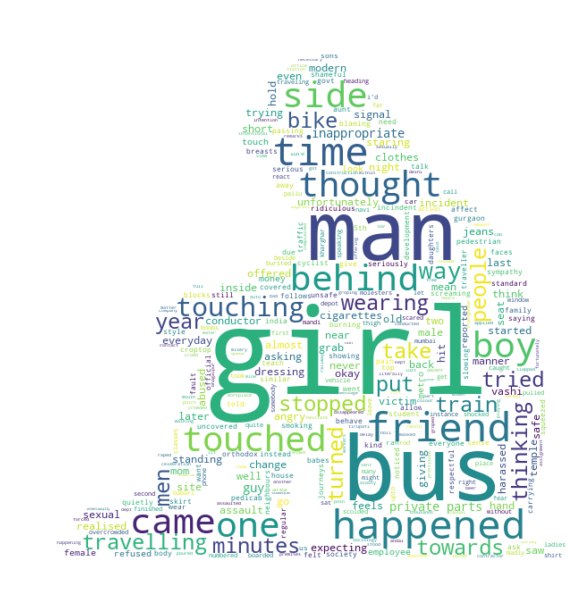

In [14]:
#Without tfidf
WordCloud_gen('TouchingGroping')

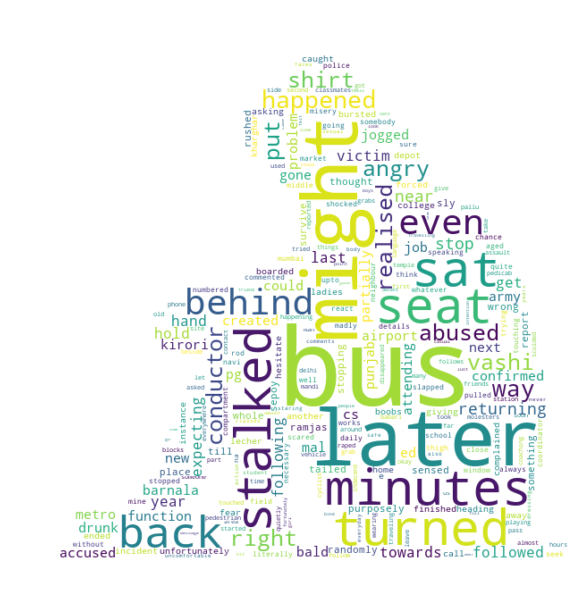

In [15]:
#Third category WITH tfidf, can you guess it?
WordCloud_gen('tfidf', corpus_index=3)

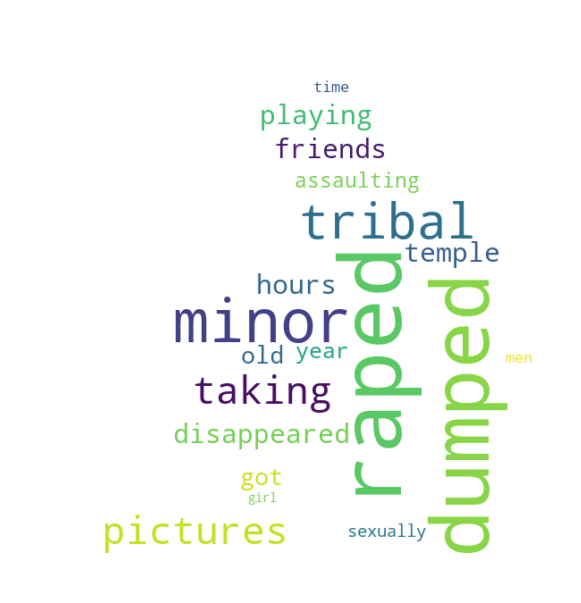

In [16]:
#Can you guess it?
WordCloud_gen('tfidf', corpus_index=6)

### Name Entity Recognition NER

The Idea is to try to extract meaningful entities among the categories helping to determine their inter-correlations. 

Note: At the end it wasn't necessary due to the good result of the classifier after hyperparameter tuning.

In [17]:
#Using nltk entities
category = open('TouchingGroping.txt', 'r')
content = category.read()

# Tokenize the article into sentences: sentences
sentences = nltk.sent_tokenize(content)

# Tokenize each sentence into words: token_sentences
token_sentences = [word_tokenize(sent) for sent in sentences]

# Tag each tokenized sentence into parts of speech: pos_sentences
pos_sentences = [nltk.pos_tag(sent) for sent in token_sentences] 

# Create the named entity chunks: chunked_sentences
chunked_sentences = nltk.ne_chunk_sents(pos_sentences , binary=False)

# Test for stems of the tree with tags or NE tag
for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, "label"):# and chunk.label() == "NE":
            print(chunk)

# NNP is proper-noun-singular

(GPE Pedicab/NNP)
(GPE Gurgaon/NNP)
(GPE India/NNP)
(GPE Okay/NNP)
(ORGANIZATION Vashi/NNP)
(ORGANIZATION Vashi/NNP)
(PERSON Kharghar/NNP)
(PERSON Navi/NNP Mumbai/NNP)
(ORGANIZATION IIT/NNP)
(GPE Tirupati/NNP)
(GPE Holi/NNP)
(GPE POSH/NNP)
(ORGANIZATION Delhi/NNP)
(ORGANIZATION Andal/NNP)


['GPE', 'ORGANIZATION', 'PERSON']


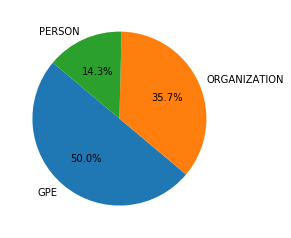

In [18]:
#Entity type participation
chunked_sentences = nltk.ne_chunk_sents(pos_sentences , binary=False)
ner_categories = defaultdict(int)

for sent in chunked_sentences:
    for chunk in sent:
        if hasattr(chunk, 'label'):
            ner_categories[chunk.label()] += 1

labels = list(ner_categories.keys())
print(labels)
values = [ner_categories.get(l) for l in labels]
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

In [48]:
#TODO loop over all categories, think how you are going to use this information
from spacy import displacy

#Using Spacy
category = open('TouchingGroping.txt', 'r')
content = category.read()

nlp = spacy.load('en')
nlp.entity
doc = nlp(content)
items = [x.text for x in doc.ents]
labels = [x.label_ for x in doc.ents]
labels_type =  np.unique(np.array(labels))
entity_dict = dict((k, []) for k in labels_type)

for item, label in zip(items, labels):
  entity_dict[label].append(item)
  
for ent_type in labels_type:
  counter_ = Counter(entity_dict[ent_type])
  counter = Counter(entity_dict[ent_type]).most_common(5)
  top5_list = []
  top5 = ''
  for word_count in counter:
    word = word_count[0]
    if type(word) is str:
      top5 += ', ' + word if word.isalpha() else ''
      top5_list.append(word) if word.isalpha() else ''
  top5_dict = dict((k, ['#']) for k in top5_list)
  html = displacy.render(nlp('; '.join(top5_list)), style="ent", jupyter=True, manual=False) if len(top5_list)>0 else None

## Supervised Text Classification
Using tf-idf feautures (weights) and word count. And a binary output where usually there is the target variables are a binary encoding of the SH category.

In [0]:
#First I want to pass the list in CATEGORY to a vector of 1s and 0s
categories_bool = [[]]
category_bool = [0]*len(categories)

for index, row in report_1.iterrows():
  row_category = row['CATEGORY']
  for category in row_category:
    index_match = list(filter(lambda x: categories[x][0] == category.lstrip(), range(len(categories))))
    if len(index_match) == 1:
      category_bool[index_match[0]] = 1 if len(index_match) != 0 else None
  categories_bool.append(category_bool)
  category_bool = [0]*len(categories)
del(categories_bool[0])

#Expand the column CATEGORY by its boolean representation
category_list = [cat[0] for cat in categories]
df_categories = pd.DataFrame.from_records(categories_bool)
df_categories.columns = category_list
df_ready = pd.concat([report_1, df_categories], axis=1)

In [85]:
df_ready.head()


,#,INCIDENT TITLE,INCIDENT DATE,LOCATION,DESCRIPTION,CATEGORY,LATITUDE,LONGITUDE,More Info,Touching /Groping,Catcalls/Whistles,Sexual Invites,Stalking,Others,Commenting,Rape / Sexual Assault,North East India Report,Indecent exposure,Chain Snatching,Ogling/Facial Expressions/Staring,Taking pictures,Poor / No Street Lighting,Online Harassment
0,12152.0,touching,27-05-2019 15:00,"Chanakya Puri, Danapur Nizamat, Patna, Bihar 8...",My school auto driver always use to stare at m...,[Touching /Groping],25.625485,85.055803,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12149.0,whistling,17-05-2019 19:00,"Near Nissan Showroom, Bailey Rd, Patna, Bihar ...",I was in market with my mom. There I saw a man...,[Catcalls/Whistles],25.619769,85.045596,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12213.0,sexual invite,15-05-2019 15:03,"Makina, Nairobi, Kenya",there is a girl whom boys have been writing a ...,[Sexual Invites],-1.308482,36.789595,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,12199.0,sexual invite,14-05-2019 14:13,"Makina, Nairobi, Kenya",there is a girl who is being disturbed y a bo...,[Sexual Invites],-1.308482,36.789595,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12206.0,sexual invite,13-05-2019 14:45,"Makina, Nairobi, Kenya",there are some boys who likes disturbing a gir...,[Sexual Invites],-1.308482,36.789595,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After this point we created the second version of our dataset: safecity_reports_07082019

In [0]:
#Load the database version
report_1 = pd.read_csv('safecity_reports_07082019.csv')
report_1 = report_1[pd.notna(report_1['DESCRIPTION'])]

#Select x and Y (without HumanTrafficking or PettyRobbery is til column 28)
x_report_1 = report_1[report_1.columns[4]]
y_report_1 = report_1[report_1.columns[14:28]]
X_train, X_test, y_train, y_test = train_test_split(x_report_1, y_report_1, test_size=0.2, random_state=17)
categories = y_train.columns

In [0]:
#CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
X_train = X_train[pd.notna(X_train)]
count_train = count_vectorizer.fit_transform(X_train.values)
X_test = X_test[pd.notna(X_test)]
count_test = count_vectorizer.transform(X_test.values)

#TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)
tfidf_test = tfidf_vectorizer.transform(X_test.values)

In [10]:
print(X_train.values[0])
print(count_train[0])

two boys commented on me and my sister while we were returning home from the market
  (0, 1144)	1
  (0, 1687)	1
  (0, 7208)	1
  (0, 6563)	1
  (0, 3616)	1
  (0, 4839)	1


In [0]:
#Hyperparameters preprocess

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

pattern_wd_eng = (r'[A-Za-z]+') 

lowers = [entry.lower() for entry in X_train.values] #1

def no_stopwords(dt_list, option=1):
  tokens = [re.findall(pattern_wd_eng, t) for t in dt_list] if option==1 else [word_tokenize(entry) for entry in dt_list]
  no_stops = [t for t in tokens if t not in sw.words('english')]
  return no_stops

In [0]:
no_stops = no_stopwords(lowers) #better
alternative = no_stopwords(lowers, option=2)

In [26]:
lemm = []
stemm = []
for category in tqdm(range(len(no_stops))):
  lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in no_stops[category]] #2
  lemm.append(lemmatized)
  stemmed = [stemmer.stem(word) for word in lemmatized] #3
  stemm.append(stemmed)

In [27]:
# Check whether the two vectorizers are equal (They shouldn't be)
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
difference = set(count_df.columns) - set(tfidf_df.columns)
print('Equality Test output: ', count_df.equals(tfidf_df))

Equality Test output:  False


Explain difference between OneVsRestClassifier and MultiOutputClassifier

####Naive Bayes
Next: SVM or linear models for tf-idf; create a function to iterate over the alphas from 0 to 1 with steps 0.1 with np.arange()

In [11]:
print(count_train.shape)
print(y_train.shape)
y_train.head()

(8844, 8894)
(8844, 14)


,Touching /Groping,Catcalls/Whistles,Sexual Invites,Stalking,Others,Commenting,Rape / Sexual Assault,North East India Report,Indecent Exposure/Masturbation in public,Chain Snatching,Ogling/Facial Expressions/Staring,Taking pictures,Poor / No Street Lighting,Online Harassment
3742,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2876,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7655,0,1,0,0,1,1,0,0,0,0,1,0,0,0
6048,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4403,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
#Initial test for one category, CountVectorizer()
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train.iloc[:,0])
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test.iloc[:,0], pred)
print('Test accuracy is {}'.format(score))
metrics.confusion_matrix(y_test.iloc[:,0], pred)

Test accuracy is 0.8611488014473089


array([[1497,   80],
       [ 227,  407]])

In [13]:
#Initial test for one category, TfidfVectorizer()
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train.iloc[:,0])
pred = nb_classifier.predict(tfidf_test)
score = metrics.accuracy_score(y_test.iloc[:,0], pred)
print('Test accuracy is {}'.format(score))
metrics.confusion_matrix(y_test.iloc[:,0], pred, labels=[0,1])

Test accuracy is 0.80958842152872


array([[1552,   25],
       [ 396,  238]])

In [14]:
#Inspecting the model
# Get the class labels: class_labels
class_labels = nb_classifier.classes_
# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()
# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))
print(class_labels, feat_with_weights[300:350])

[0 1] [(-9.687577285651056, 'aren'), (-9.687577285651056, 'arena'), (-9.687577285651056, 'ares'), (-9.687577285651056, 'arested'), (-9.687577285651056, 'arguing'), (-9.687577285651056, 'arival'), (-9.687577285651056, 'armbushed'), (-9.687577285651056, 'armed'), (-9.687577285651056, 'army'), (-9.687577285651056, 'arre'), (-9.687577285651056, 'arrest'), (-9.687577285651056, 'arrested'), (-9.687577285651056, 'arrival'), (-9.687577285651056, 'arrives'), (-9.687577285651056, 'arriving'), (-9.687577285651056, 'arterial'), (-9.687577285651056, 'article'), (-9.687577285651056, 'artid'), (-9.687577285651056, 'artificial'), (-9.687577285651056, 'arts'), (-9.687577285651056, 'aruvathimuvar'), (-9.687577285651056, 'asgarali'), (-9.687577285651056, 'ashok'), (-9.687577285651056, 'asians'), (-9.687577285651056, 'aside'), (-9.687577285651056, 'asif'), (-9.687577285651056, 'aso'), (-9.687577285651056, 'aspx'), (-9.687577285651056, 'assassinating'), (-9.687577285651056, 'assaulter'), (-9.68757728565105

#####Pipeline definition
Using OneVsRestClassifier and MiltiOutputClassifier strategies.

In [0]:
#Pipelines
NB_pipeline_CountV = Pipeline([('count', CountVectorizer(stop_words='english')), 
                        ('clf', OneVsRestClassifier(MultinomialNB())),])
NB_pipeline_TfidfV = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                        ('clf', OneVsRestClassifier(MultinomialNB())),])
NB_pipeline_CountV2 = Pipeline([('count2', CountVectorizer(stop_words='english')), 
                        ('clf', MultiOutputClassifier(MultinomialNB())),]) #do tuning for this one as well

In [0]:
#For OneVsRestClasifier strategy
from sklearn.metrics import precision_recall_fscore_support
import joblib

category_list_save_model = ['TouchingGroping','CatcallsWhistles', 'SexualInvites', 'Stalking', 'Others', 'Commenting',
                 'RapeSexualAssault', 'NorthEastIndiaReport', 'IndecentExposure', 'ChainSnatching', 
                 'OglingFacialExpressionsStaring', 'TakingPictures', 'PoorNoStreetLighting', 'OnlineHarassment']

def execute(pipeline, X_train=X_train, X_test=X_test, confusion_matrix=False, verbose=True):

  accuracies=[]
  
  for category, cat_name in (tqdm(zip(categories, category_list_save_model)) if verbose else zip(categories, category_list_save_model)):
    pipeline.fit(X_train, y_train[category])
    prediction = pipeline.predict(X_test)
    
    if len(X_test) == 1:
      print('Prediction for {} is {}'.format(category, prediction)) if verbose else None
    else:
      print('Test accuracy for {} is {}'.format(category, metrics.accuracy_score(y_test[category], prediction))) if verbose else None
      accuracies.append(metrics.accuracy_score(y_test[category], prediction))
      print(metrics.confusion_matrix(y_test[category], prediction, labels=[0,1])) if confusion_matrix else None
      print('precision_recall_fscore_support_weighted', precision_recall_fscore_support(y_test[category], prediction, average='weighted')) if verbose else None

    filename = 'model_'+cat_name+'.sav'
    joblib.dump(pipeline, filename)
  print('mean: ', sum(accuracies)/len(accuracies)) if verbose and len(accuracies)!=0 else None
  return accuracies

def execute_mean(pipeline, X_train=X_train, X_test=X_test, confusion_matrix=False, verbose=True):

  accuracies=[]
  for category in (tqdm(categories) if verbose else categories):
    pipeline.fit(X_train, y_train[category])
    prediction = pipeline.predict(X_test)
    
    if len(X_test) == 1:
      print('Prediction for {} is {}'.format(category, prediction)) if verbose else None
    else:
      print('Test accuracy for {} is {}'.format(category, metrics.accuracy_score(y_test[category], prediction))) if verbose else None
      accuracies.append(metrics.accuracy_score(y_test[category], prediction))
      print(metrics.confusion_matrix(y_test[category], prediction, labels=[0,1])) if confusion_matrix else None
      print('precision_recall_fscore_support_weighted', precision_recall_fscore_support(y_test[category], prediction, average='weighted')) if verbose else None
  
  mean = sum(accuracies)/len(accuracies)
  print('mean: ', mean) if verbose else None
  return accuracies, mean

In [0]:
#For MultOutputClasifier strategy
def execute2(pipeline, X_train=X_train, X_test=X_test, confusion_matrix=False, verbose=True):
  
  accuracies=[]
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
      
  if confusion_matrix:
    y_test_list = y_test.values.tolist()
    y_test_array = np.array(y_test_list)
    y_pred_list = y_pred.tolist()
    y_pred_array = np.array(y_pred_list)
    conf_mat = metrics.multilabel_confusion_matrix(y_test_array, y_pred_array)
    print('Test accuracy is {}'.format(metrics.accuracy_score(y_test_array, y_pred_array)))
    print(conf_mat)
      
  return accuracies

In [106]:
acc = execute(NB_pipeline_CountV, confusion_matrix=False)

Test accuracy for Touching /Groping is 0.6958207669108143
precision_recall_fscore_support_weighted (0.6251873584329182, 0.6958207669108143, 0.6209957673938231, None)
Test accuracy for Catcalls/Whistles is 0.7492460146488582
precision_recall_fscore_support_weighted (0.6360229652415259, 0.7492460146488582, 0.6724469893862954, None)
Test accuracy for Sexual Invites is 0.8914261094355881
precision_recall_fscore_support_weighted (0.857508284451787, 0.8914261094355881, 0.861071776313176, None)
Test accuracy for Stalking is 0.9086600603188281
precision_recall_fscore_support_weighted (0.864591430771543, 0.9086600603188281, 0.8780745004871262, None)
Test accuracy for Others is 0.8892718655751831
precision_recall_fscore_support_weighted (0.817625787338214, 0.8892718655751831, 0.8451475966663493, None)
Test accuracy for Commenting is 0.6174062903920724
precision_recall_fscore_support_weighted (0.5878821183823171, 0.6174062903920724, 0.5806318482092814, None)
Test accuracy for Rape / Sexual Assaul

/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy for Online Harassment is 0.999569151227919
precision_recall_fscore_support_weighted (0.9991384880865023, 0.999569151227919, 0.9993537732595441, None)

mean:  0.874561457499846


In [108]:
acc = execute2(NB_pipeline_CountV2, confusion_matrix=True) #the sme onevsrest

Test accuracy is 0.05040930633347695
[[[1553   92]
  [ 614   62]]

 [[1724   70]
  [ 512   15]]

 [[2039   32]
  [ 220   30]]

 [[2099   24]
  [ 188   10]]

 [[2061   17]
  [ 240    3]]

 [[1213  231]
  [ 657  220]]

 [[2181   17]
  [ 122    1]]

 [[2305    8]
  [   8    0]]

 [[2161   16]
  [ 143    1]]

 [[2217   15]
  [  89    0]]

 [[1805   37]
  [ 454   25]]

 [[2133   13]
  [ 175    0]]

 [[2240   12]
  [  69    0]]

 [[2320    0]
  [   1    0]]]


In [109]:
acc = execute(NB_pipeline_TfidfV)

Test accuracy for Touching /Groping is 0.7109004739336493
precision_recall_fscore_support_weighted (0.6847423783030625, 0.7109004739336493, 0.5990610506339752, None)
Test accuracy for Catcalls/Whistles is 0.7729426971133132
precision_recall_fscore_support_weighted (0.7113332751926129, 0.7729426971133132, 0.6755675343198938, None)
Test accuracy for Sexual Invites is 0.8931495045239121
precision_recall_fscore_support_weighted (0.8692783112465179, 0.8931495045239121, 0.8452006948787151, None)
Test accuracy for Stalking is 0.9159844894442051
precision_recall_fscore_support_weighted (0.8956034044507124, 0.9159844894442051, 0.8794197663853947, None)
Test accuracy for Others is 0.8948728996122362
precision_recall_fscore_support_weighted (0.8015283988768219, 0.8948728996122362, 0.8456325081374382, None)
Test accuracy for Commenting is 0.6311934510986643
precision_recall_fscore_support_weighted (0.618508055586394, 0.6311934510986643, 0.5268819835097435, None)
Test accuracy for Rape / Sexual Ass

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy for Indecent exposure is 0.9375269280482551
precision_recall_fscore_support_weighted (0.8797397079142463, 0.9375269280482551, 0.9077145307365139, None)
Test accuracy for Chain Snatching is 0.961654459284791
precision_recall_fscore_support_weighted (0.9247792990623238, 0.961654459284791, 0.942856469634814, None)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy for Ogling/Facial Expressions/Staring is 0.7966393795777682
precision_recall_fscore_support_weighted (0.7839013026231204, 0.7966393795777682, 0.712508062192824, None)
Test accuracy for Taking pictures is 0.9241706161137441
precision_recall_fscore_support_weighted (0.8548578199052131, 0.9241706161137441, 0.888163968732689, None)
Test accuracy for Poor / No Street Lighting is 0.96984058595433
precision_recall_fscore_support_weighted (0.9414142239522204, 0.96984058595433, 0.955416010310215, None)


/usr/local/lib/python3.6/dist-packages/sklearn/multiclass.py:76: UserWarning: Label not 0.0 is present in all training examples.
  str(classes[c]))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy for Online Harassment is 0.999569151227919
precision_recall_fscore_support_weighted (0.9991384880865023, 0.999569151227919, 0.9993537732595441, None)

mean:  0.8822551855727211


#####Testing

In [21]:
test_string = [""""He started rubbing my shoulders, telling me I looked stressed. Then he went down in my shirt. 
                  He walked around the living room area and he came back. That is when he touched my breast.
                  Then he grabbed my waist of my pants and also grabbed my hair as I tried to leave. I made it to the door and left.
                  It happened so quickly. I was just trying to get out of the townhouse"""]

acc = execute(NB_pipeline_CountV, X_test = test_string)
acc = execute(NB_pipeline_TfidfV,  X_test = test_string)

Prediction for Touching /Groping is [1]
Prediction for Catcalls/Whistles is [0]
Prediction for Sexual Invites is [0]
Prediction for Stalking is [0]
Prediction for Others is [0]
Prediction for Commenting is [0]
Prediction for Rape / Sexual Assault is [0]
Prediction for North East India Report is [0]
Prediction for Indecent Exposure/Masturbation in public is [0]
Prediction for Chain Snatching is [0]
Prediction for Ogling/Facial Expressions/Staring is [0]
Prediction for Taking pictures is [0]
Prediction for Poor / No Street Lighting is [0]
Prediction for Online Harassment is [0]



Prediction for Touching /Groping is [1]
Prediction for Catcalls/Whistles is [0]
Prediction for Sexual Invites is [0]
Prediction for Stalking is [0]
Prediction for Others is [0]
Prediction for Commenting is [0]
Prediction for Rape / Sexual Assault is [0]
Prediction for North East India Report is [0]
Prediction for Indecent Exposure/Masturbation in public is [0]
Prediction for Chain Snatching is [0]
Prediction for Ogling/Facial Expressions/Staring is [0]
Prediction for Taking pictures is [0]
Prediction for Poor / No Street Lighting is [0]
Prediction for Online Harassment is [0]



#####Hyperparameter Tuning
alpha : Increase the probablities of all bigrams in your non-maximum likelihood equation (Since we are changing the counts from what they occurred in hopes to make it better) by 1 to make everything non-zero. That increase by 1 is called adding the pseudocount or as you know it as α. Now, α=1 may not always give the most accurate probablities and hence they could attain any finite non-negative integer. The way to know what α gives the most accurate responses is through iterating over all values of α on the training set unfortunately

In [22]:
#Hyperparameter Tuning CountVectorizer
alphas_out = []

for alpha in tqdm(np.arange(0,1,0.05)):
  NB_pipeline_CountV = Pipeline([('count', CountVectorizer(stop_words='english')),
                                 ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None, alpha=alpha))),])
  acc = execute(NB_pipeline_CountV, verbose=False)
  alphas_out.append(acc)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

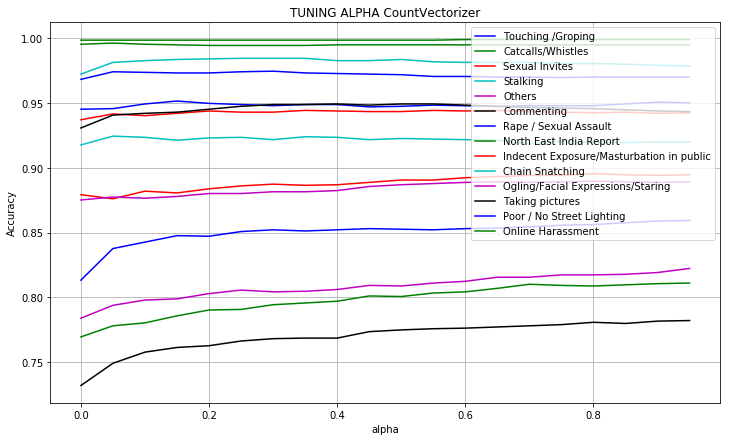

In [23]:
cycol = cycle('bgrcmk')
accuracies = []
plt.figure(figsize=(12,7))

for category in range(len(categories)):
  for alpha in alphas_out:
    accuracies.append(alpha[category])

  alpha_array = np.arange(0.0,1.0,0.05)
  plt.plot(alpha_array, accuracies, c=next(cycol))
  plt.xlabel('alpha')
  plt.ylabel('Accuracy')
  plt.title('TUNING ALPHA CountVectorizer')
  accuracies = []
  
plt.gca().legend(categories, loc='upper right')  
plt.grid()  
plt.show()

In [24]:
#Hyperparameter Tuning TfidfVectorizer
alphas_out = []

for alpha in tqdm(np.arange(0,1,0.05)):
  NB_pipeline_TfidfV = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                                 ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None, alpha=alpha))),])
  acc = execute(NB_pipeline_TfidfV, verbose=False)
  alphas_out.append(acc)

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/usr/local/lib/python3.6/dist-packages/sklearn/nai

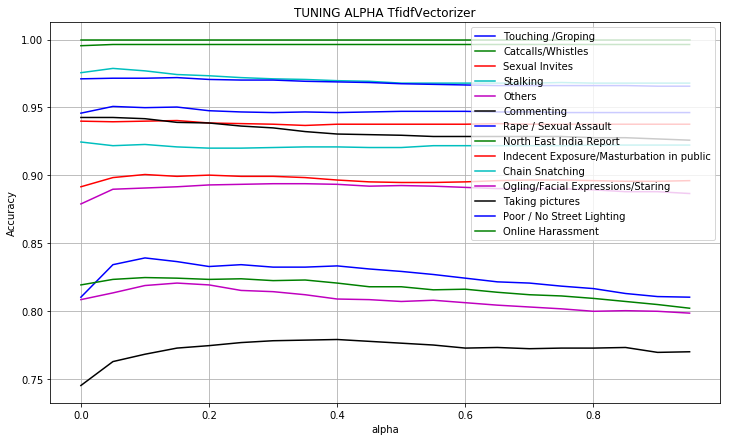

In [25]:
cycol = cycle('bgrcmk')
accuracies = []
plt.figure(figsize=(12,7))

for category in range(len(categories)):
  for alpha in alphas_out:
    accuracies.append(alpha[category])

  alpha_array = np.arange(0.0,1.0,0.05)
  plt.plot(alpha_array, accuracies, c=next(cycol))
  plt.xlabel('alpha')
  plt.ylabel('Accuracy')
  plt.title('TUNING ALPHA TfidfVectorizer')
  accuracies = []

plt.gca().legend(categories, loc='upper right') 
plt.grid()  
plt.show()

So for 'tf-idf' alpha optimal (smoothing) = 0.3; for 'count' alpha is 1 (as expected). SVM could work better for tf-idf.

####Support Vector Machine

In [26]:
SVM_pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', OneVsRestClassifier(LinearSVC()))])

acc = execute(SVM_pipeline, verbose=True)

Test accuracy for Touching /Groping is 0.8593396653098145
precision_recall_fscore_support_weighted (0.8566603480443372, 0.8593396653098145, 0.8536494587125382, None)
Test accuracy for Catcalls/Whistles is 0.8299412030755314
precision_recall_fscore_support_weighted (0.8197035704736576, 0.8299412030755314, 0.8118214367345652, None)
Test accuracy for Sexual Invites is 0.9054726368159204
precision_recall_fscore_support_weighted (0.8870760016606434, 0.9054726368159204, 0.8853861580346564, None)
Test accuracy for Stalking is 0.9280868385345997
precision_recall_fscore_support_weighted (0.9154630313488049, 0.9280868385345997, 0.9175483142616552, None)
Test accuracy for Others is 0.8860244233378561
precision_recall_fscore_support_weighted (0.8590918657153478, 0.8860244233378561, 0.8616267965434834, None)
Test accuracy for Commenting is 0.7919493441881501
precision_recall_fscore_support_weighted (0.7898503863905422, 0.7919493441881501, 0.7878419508506026, None)
Test accuracy for Rape / Sexual As

#####Hyperparameter Tuning

In [0]:
#Hyperparameter Tuning SVM 1 (This cell takes to much to run)
#Save results name and score in a dictionary

from sklearn import svm

acc_dict = {}
kernels = ['linear', 'rbf', 'poly']
gammas = ['scale', 0.1, 1, 10, 100]
cs = [0.1, 1] #, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6]

for c in cs:
  for kernel in tqdm(kernels):
    print('\nSVC with kernel = {}, gamma = auto, c = {}'.format(kernel, c))
    SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                    ('tfidf', TfidfTransformer()),
                                    ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, gamma='auto', C=c)))])
    acc_k, m_k = execute_mean(SVM_pipeline_kernel, verbose=False)
    acc_dict.update({kernel+'_auto_'+str(c):m_k})

    if kernel != 'linear':
      for gamma in gammas: 
        if kernel == 'poly':
          for degree in degrees:
            print('\nSVC with kernel = {}, gamma = {}, c = {} and degree = {}'.format(kernel, gamma, c, degree))
            SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                          ('tfidf', TfidfTransformer()),
                                          ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, gamma=gamma, C=c, degree=degree)))])
            acc_kgd, m_kgd = execute_mean(SVM_pipeline_kernel, verbose=False)
            acc_dict.update({kernel+'_'+str(gamma)+'_'+str(c)+'_'+str(degree):m_kgd})

        else:
          print('\nSVC with kernel = {}, c = {} and gamma = {}'.format(kernel, c, gamma))
          SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                          ('tfidf', TfidfTransformer()),
                                          ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, C=c, gamma=gamma)))])
          acc_kg, m_kg = execute_mean(SVM_pipeline_kernel, verbose=False)
          acc_dict.update({kernel+'_'+str(gamma)+'_'+str(c):m_kg})

In [0]:
np.save('hyper_results_2.npy', acc_dict) 

In [0]:
#Hyperparameter Tuning SVM 2 (This cell takes to much to run)

from sklearn import svm

kernels = ['linear', 'rbf', 'poly']
gammas = ['scale', 0.1, 1, 10, 100]
cs = [10, 100] #1000]
degrees = [0, 1, 2, 3, 4, 5, 6]

for c in cs:
  for kernel in tqdm(kernels):
    print('\nSVC with kernel = {}, gamma = auto, c = {}'.format(kernel, c))
    SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                    ('tfidf', TfidfTransformer()),
                                    ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, gamma='auto', C=c)))])
    acc_k, m_k = execute_mean(SVM_pipeline_kernel, verbose=False)
    acc_dict.update({kernel+'_auto_'+str(c):m_k})

    if kernel != 'linear':
      for gamma in gammas: 
        if kernel == 'poly':
          for degree in degrees:
            print('\nSVC with kernel = {}, gamma = {}, c = {} and degree = {}'.format(kernel, gamma, c, degree))
            SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                          ('tfidf', TfidfTransformer()),
                                          ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, gamma=gamma, C=c, degree=degree)))])
            acc_kgd, m_kgd = execute_mean(SVM_pipeline_kernel, verbose=False)
            acc_dict.update({kernel+'_'+str(gamma)+'_'+str(c)+'_'+str(degree):m_kgd})

        else:
          print('\nSVC with kernel = {}, c = {} and gamma = {}'.format(kernel, c, gamma))
          SVM_pipeline_kernel = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                                          ('tfidf', TfidfTransformer()),
                                          ('clf', OneVsRestClassifier(svm.SVC(kernel=kernel, C=c, gamma=gamma)))])
          acc_kg, m_kg = execute_mean(SVM_pipeline_kernel, verbose=False)
          acc_dict.update({kernel+'_'+str(gamma)+'_'+str(c):m_kg})

np.save('hyper_results_2.npy', acc_dict) 

#####Choosing the best model

In [0]:
# Load
read_dictionary = np.load('hyper_results_2.npy', allow_pickle=True).item()
print(read_dictionary)

In [27]:
SVM_pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', OneVsRestClassifier(svm.SVC(kernel='linear', gamma='auto', C=1.0)))])

acc = execute(SVM_pipeline, verbose=True)

Test accuracy for Touching /Groping is 0.8683853459972863
precision_recall_fscore_support_weighted (0.8684271467151216, 0.8683853459972863, 0.8616125545209374, None)
Test accuracy for Catcalls/Whistles is 0.8403437358661239
precision_recall_fscore_support_weighted (0.8428692901583692, 0.8403437358661239, 0.8160778364089479, None)
Test accuracy for Sexual Invites is 0.9054726368159204
precision_recall_fscore_support_weighted (0.8929826717402044, 0.9054726368159204, 0.8759274231155673, None)
Test accuracy for Stalking is 0.9357756671189507
precision_recall_fscore_support_weighted (0.9270302368734259, 0.9357756671189507, 0.9237332189256853, None)
Test accuracy for Others is 0.8959746720940751
precision_recall_fscore_support_weighted (0.898105709696034, 0.8959746720940751, 0.8594374979294781, None)
Test accuracy for Commenting is 0.8136589778380823
precision_recall_fscore_support_weighted (0.8158081874009054, 0.8136589778380823, 0.807631176621091, None)
Test accuracy for Rape / Sexual Assa

In [0]:
#load models
#Use this function to load the pretrained model
clf = joblib.load('filename.joblib') 

####Logistic Regression

In [11]:
#Edit...
logit_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                          ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
acc_logit = execute(logit_pipeline, verbose=True)

Test accuracy for Touching /Groping is 0.8611488014473089
precision_recall_fscore_support_weighted (0.8646360721354098, 0.8611488014473089, 0.8514041284501833, None)
Test accuracy for Catcalls/Whistles is 0.8344640434192673
precision_recall_fscore_support_weighted (0.835283565692548, 0.8344640434192673, 0.8083733797370136, None)
Test accuracy for Sexual Invites is 0.9072817729534147
precision_recall_fscore_support_weighted (0.9007699463202034, 0.9072817729534147, 0.8772184411916784, None)
Test accuracy for Stalking is 0.9194934418815016
precision_recall_fscore_support_weighted (0.8970543821705647, 0.9194934418815016, 0.8993950987183286, None)
Test accuracy for Others is 0.8900949796472184
precision_recall_fscore_support_weighted (0.8798268569401684, 0.8900949796472184, 0.8492423848713796, None)
Test accuracy for Commenting is 0.8086838534599728
precision_recall_fscore_support_weighted (0.8123728564984402, 0.8086838534599728, 0.8013955468117723, None)
Test accuracy for Rape / Sexual Ass

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy for Indecent Exposure/Masturbation in public is 0.9412030755314338
precision_recall_fscore_support_weighted (0.9307309764607938, 0.9412030755314338, 0.9199819659435003, None)
Test accuracy for Chain Snatching is 0.9828132066938037
precision_recall_fscore_support_weighted (0.981876422569708, 0.9828132066938037, 0.9811507195879123, None)
Test accuracy for Ogling/Facial Expressions/Staring is 0.8281320669380371
precision_recall_fscore_support_weighted (0.8270337928845045, 0.8281320669380371, 0.790906921888323, None)
Test accuracy for Taking pictures is 0.9502487562189055
precision_recall_fscore_support_weighted (0.949328082976112, 0.9502487562189055, 0.9406492246643327, None)
Test accuracy for Poor / No Street Lighting is 0.9696969696969697
precision_recall_fscore_support_weighted (0.9687435286808862, 0.9696969696969697, 0.9597716031659181, None)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy for Online Harassment is 1.0
precision_recall_fscore_support_weighted (1.0, 1.0, 1.0, None)

mean:  0.9176196937390966


So this model's performance is on averga no better than the SVM model. So we consider logistic regression for comparisson but doing hyperparameter tuning is not a priority. 

##Models Comparison

In [12]:
#Naive Bayes best model
NB_pipeline_CountV = Pipeline([('count', CountVectorizer(stop_words='english')), 
                        ('clf', OneVsRestClassifier(MultinomialNB())),])

acc_NB = execute(NB_pipeline_CountV, verbose=True)

#SVM base and after hyperparameter tuning
SVM_pipeline = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', OneVsRestClassifier(LinearSVC()))])

acc_SVM = execute(SVM_pipeline, verbose=True)

SVM_pipeline_hyper = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', OneVsRestClassifier(svm.SVC(kernel='linear', gamma='auto', C=1.0)))])

acc_SVM_hyper = execute(SVM_pipeline_hyper, verbose=True)

#Logistic Regression
logit_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                          ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),])
acc_logit = execute(logit_pipeline, verbose=True)

Test accuracy for Touching /Groping is 0.8611488014473089
precision_recall_fscore_support_weighted (0.8589813317516827, 0.8611488014473089, 0.855136478107857, None)
Test accuracy for Catcalls/Whistles is 0.8132066938037087
precision_recall_fscore_support_weighted (0.7995591486149929, 0.8132066938037087, 0.8016860392788738, None)
Test accuracy for Sexual Invites is 0.8941655359565808
precision_recall_fscore_support_weighted (0.8645159629160971, 0.8941655359565808, 0.8690519930007954, None)
Test accuracy for Stalking is 0.9199457259158752
precision_recall_fscore_support_weighted (0.8983651218820121, 0.9199457259158752, 0.9006944884433291, None)
Test accuracy for Others is 0.8891904115784712
precision_recall_fscore_support_weighted (0.864232728825344, 0.8891904115784712, 0.8591009864459133, None)
Test accuracy for Commenting is 0.7815468113975577
precision_recall_fscore_support_weighted (0.7790976814997338, 0.7815468113975577, 0.7794759101031481, None)
Test accuracy for Rape / Sexual Assa

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test accuracy for Touching /Groping is 0.8593396653098145
precision_recall_fscore_support_weighted (0.8566603480443372, 0.8593396653098145, 0.8536494587125382, None)
Test accuracy for Catcalls/Whistles is 0.8299412030755314
precision_recall_fscore_support_weighted (0.8197035704736576, 0.8299412030755314, 0.8118214367345652, None)
Test accuracy for Sexual Invites is 0.9054726368159204
precision_recall_fscore_support_weighted (0.8870760016606434, 0.9054726368159204, 0.8853861580346564, None)
Test accuracy for Stalking is 0.9280868385345997
precision_recall_fscore_support_weighted (0.9154630313488049, 0.9280868385345997, 0.9175483142616552, None)
Test accuracy for Others is 0.8860244233378561
precision_recall_fscore_support_weighted (0.8590918657153478, 0.8860244233378561, 0.8616267965434834, None)
Test accuracy for Commenting is 0.7919493441881501
precision_recall_fscore_support_weighted (0.7898503863905422, 0.7919493441881501, 0.7878419508506026, None)
Test accuracy for Rape / Sexual As

Test accuracy for Touching /Groping is 0.8683853459972863
precision_recall_fscore_support_weighted (0.8684271467151216, 0.8683853459972863, 0.8616125545209374, None)
Test accuracy for Catcalls/Whistles is 0.8403437358661239
precision_recall_fscore_support_weighted (0.8428692901583692, 0.8403437358661239, 0.8160778364089479, None)
Test accuracy for Sexual Invites is 0.9054726368159204
precision_recall_fscore_support_weighted (0.8929826717402044, 0.9054726368159204, 0.8759274231155673, None)
Test accuracy for Stalking is 0.9357756671189507
precision_recall_fscore_support_weighted (0.9270302368734259, 0.9357756671189507, 0.9237332189256853, None)
Test accuracy for Others is 0.8959746720940751
precision_recall_fscore_support_weighted (0.898105709696034, 0.8959746720940751, 0.8594374979294781, None)
Test accuracy for Commenting is 0.8136589778380823
precision_recall_fscore_support_weighted (0.8158081874009054, 0.8136589778380823, 0.807631176621091, None)
Test accuracy for Rape / Sexual Assa

Test accuracy for Touching /Groping is 0.8611488014473089
precision_recall_fscore_support_weighted (0.8646360721354098, 0.8611488014473089, 0.8514041284501833, None)
Test accuracy for Catcalls/Whistles is 0.8344640434192673
precision_recall_fscore_support_weighted (0.835283565692548, 0.8344640434192673, 0.8083733797370136, None)
Test accuracy for Sexual Invites is 0.9072817729534147
precision_recall_fscore_support_weighted (0.9007699463202034, 0.9072817729534147, 0.8772184411916784, None)
Test accuracy for Stalking is 0.9194934418815016
precision_recall_fscore_support_weighted (0.8970543821705647, 0.9194934418815016, 0.8993950987183286, None)
Test accuracy for Others is 0.8900949796472184
precision_recall_fscore_support_weighted (0.8798268569401684, 0.8900949796472184, 0.8492423848713796, None)
Test accuracy for Commenting is 0.8086838534599728
precision_recall_fscore_support_weighted (0.8123728564984402, 0.8086838534599728, 0.8013955468117723, None)
Test accuracy for Rape / Sexual Ass

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test accuracy for Indecent Exposure/Masturbation in public is 0.9412030755314338
precision_recall_fscore_support_weighted (0.9307309764607938, 0.9412030755314338, 0.9199819659435003, None)
Test accuracy for Chain Snatching is 0.9828132066938037
precision_recall_fscore_support_weighted (0.981876422569708, 0.9828132066938037, 0.9811507195879123, None)
Test accuracy for Ogling/Facial Expressions/Staring is 0.8281320669380371
precision_recall_fscore_support_weighted (0.8270337928845045, 0.8281320669380371, 0.790906921888323, None)
Test accuracy for Taking pictures is 0.9502487562189055
precision_recall_fscore_support_weighted (0.949328082976112, 0.9502487562189055, 0.9406492246643327, None)
Test accuracy for Poor / No Street Lighting is 0.9696969696969697
precision_recall_fscore_support_weighted (0.9687435286808862, 0.9696969696969697, 0.9597716031659181, None)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Test accuracy for Online Harassment is 1.0
precision_recall_fscore_support_weighted (1.0, 1.0, 1.0, None)

mean:  0.9176196937390966


In [0]:
#Helper function for coloring negatives in pandas DataFrame

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [20]:
df_acc_NB = pd.DataFrame.from_dict(dict(zip(categories.to_list(),acc_NB)), orient='index')
df_acc_SVM = pd.DataFrame.from_dict(dict(zip(categories.to_list(),acc_SVM)), orient='index')
df_acc_SVM_hyper = pd.DataFrame.from_dict(dict(zip(categories.to_list(),acc_SVM_hyper)), orient='index')
df_acc_LG = pd.DataFrame.from_dict(dict(zip(categories.to_list(),acc_logit)), orient='index')

compare = pd.concat([df_acc_NB, df_acc_SVM], axis=1)
compare = pd.concat([compare, df_acc_LG], axis=1)
compare = pd.concat([compare, df_acc_SVM_hyper], axis=1)
compare.columns = ['Acc NB', 'Acc SVM', 'Acc LG', 'Acc SVM_hyper']
compare['SVM advantage to NB'] = compare['Acc SVM'] - compare['Acc NB']
compare['SVM advantage to LG'] = compare['Acc SVM'] - compare['Acc LG']
compare['SVM_hyper advantage to SVM(1)'] = compare['Acc SVM_hyper'] - compare['Acc SVM']
compare['SVM_hyper advantage to LG(2)'] = compare['Acc SVM_hyper'] - compare['Acc LG']
compare['%(1)'] = (compare['SVM_hyper advantage to SVM(1)']*100).round(1)
compare['%(2)'] = (compare['SVM_hyper advantage to LG(2)']*100).round(1)
compare.to_csv('model_comparison.csv')
compare.style.applymap(color_negative_red)

,Acc NB,Acc SVM,Acc LG,Acc SVM_hyper,SVM advantage to NB,SVM advantage to LG,SVM_hyper advantage to SVM(1),SVM_hyper advantage to LG(2),%(1),%(2)
Touching /Groping,0.861149,0.85934,0.861149,0.868385,-0.00180914,-0.00180914,0.00904568,0.00723654,0.9,0.7
Catcalls/Whistles,0.813207,0.829941,0.834464,0.840344,0.0167345,-0.00452284,0.0104025,0.00587969,1,0.6
Sexual Invites,0.894166,0.905473,0.907282,0.905473,0.0113071,-0.00180914,0,-0.00180914,0,-0.2
Stalking,0.919946,0.928087,0.919493,0.935776,0.00814111,0.0085934,0.00768883,0.0162822,0.8,1.6
Others,0.88919,0.886024,0.890095,0.895975,-0.00316599,-0.00407056,0.00995025,0.00587969,1,0.6
Commenting,0.781547,0.791949,0.808684,0.813659,0.0104025,-0.0167345,0.0217096,0.00497512,2.2,0.5
Rape / Sexual Assault,0.949344,0.959294,0.957033,0.963817,0.00995025,0.00226142,0.00452284,0.00678426,0.5,0.7
North East India Report,0.995025,0.996834,0.996382,0.996382,0.00180914,0.000452284,-0.000452284,0,-0,0
Indecent Exposure/Masturbation in public,0.942108,0.947987,0.941203,0.950249,0.00587969,0.00678426,0.00226142,0.00904568,0.2,0.9
Chain Snatching,0.978743,0.986884,0.982813,0.985527,0.00814111,0.00407056,-0.00135685,0.0027137,-0.1,0.3


##N-grams

This part is not complete but is another improvement direction

In [0]:
#We can use sklearn.feature_selection.chi2 to find the terms that are the most correlated with each of the products:
#source: https://datascienceplus.com/multi-class-text-classification-with-scikit-learn/

from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:]